# Data import

In [117]:
import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt
from easymoney.money import EasyPeasy
import sklearn.model_selection as sk
import warnings
warnings.filterwarnings('ignore')

Helper functions

In [118]:
def split_profession(x):
    if type(x) == str:
        return str(x).split(',')
    else:
        return np.nan

def cast_count(cast_age):
    return len(cast_age[~np.isnan(cast_age)])

def keep_numbers(revenue):
    """Function to convert revenue string to a number, we only do it for revenue in dollars
    Because we did not manage to find conversion rates for movies from <2000"""
    if revenue == None or revenue[0] != '$':
        return np.nan
    return int(re.sub("[^0-9]","", str(revenue)))

def bootstrap_mean_ci(data, percentile, n_sample):
    
    sample_means = []
    for i in range(n_sample):
        sample = np.random.choice(data, len(data))
        sample_means.append(np.nanmean(sample))
    
    return [np.round(np.percentile(sample_means, percentile), 3), \
            np.round(np.percentile(sample_means, 100-percentile), 3)]

def bootstrap_median_ci(data, percentile, n_sample):
    
    sample_medians = []
    for i in range(n_sample):
        sample = np.random.choice(data, len(data))
        sample_medians.append(np.nanmedian(sample))
    
    return [np.round(np.percentile(sample_medians, percentile), 3), \
            np.round(np.percentile(sample_medians, 100-percentile), 3)]

def normalize_inflation(revenue, year):
    """Take inflation into account, no data available before 1960 """
    if np.isnan(revenue) or np.isnan(year) or year < 1960:
        return np.nan
    return ep.normalize(amount=revenue, region="US", from_year=year, to_year="latest", base_currency="USD")

normalize_inflation = np.vectorize(normalize_inflation)

def df_crossjoin(df):
    df['tmpkey'] = 1
    res = pd.merge(df, df, on='tmpkey').drop('tmpkey', axis=1)
    df.drop('tmpkey', axis=1, inplace=True)
    return res


def jaccard_similarity(list1, list2):
    s1 = set(list1)
    s2 = set(list2)
    return np.round(len(s1.intersection(s2)) / len(s1.union(s2)),2)

In [119]:
#scraped files
movies = pd.read_pickle('pickles/complete_movies.pkl')
cast = pd.read_pickle('pickles/complete_cast.pkl') 

#files downloaded from the imdb website
movies_file = pd.read_csv('data/title.basics.tsv.gz', sep='\t', na_values= '\\N')
people_file = pd.read_csv('data/name.basics.tsv.gz', sep='\t', converters={'primaryProfession': split_profession},\
                        na_values= '\\N')
movie_ratings = pd.read_csv("data/title.ratings.tsv.gz", sep='\t')
movie_ratings=movie_ratings.drop_duplicates()
movie_akas= pd.read_csv("data/title.akas.tsv.gz", sep='\t')

We merge the information from the imdb files with the scraped information

In [120]:
movies_file = movies_file[movies_file['titleType'] == 'movie']
movies_file = movies_file.drop(['titleType', 'endYear'], axis=1)
movies = movies.merge(movies_file, how='outer', on='tconst')

###### We start by checking if the years from the scraping and the imdb files are the same

In [121]:
# We extract the year from the datetime variables
date_to_year = [lambda x: np.nan if (x == None) else x.year]
movies['testYear'] = movies['releaseDate'].apply(date_to_year)

diffs = (movies['testYear'] - movies['startYear'])
print('There is {} movies where the scraped year is not the same as in the files'\
      .format((diffs != 0.0).sum()-(diffs.isna()).sum()))

There is 32639 movies where the scraped year is not the same as in the files


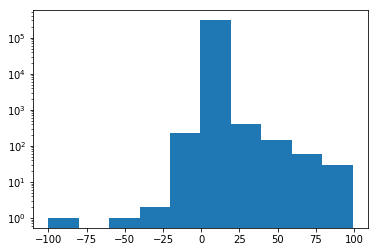

In [122]:
plt.hist(diffs[~np.isnan(diffs)]);
plt.yscale('log', nonposy='clip')

###### We use the scraped cast to get an median age of each cast, we do not use an average as the data contains a lot of outliers.

In [123]:
people_file = people_file.explode('primaryProfession')
cast = cast.explode('cast')
people_year = people_file.drop(['primaryName', 'deathYear', 'primaryProfession', 'knownForTitles'], axis=1)
cast = cast.merge(people_year, how='inner', left_on = 'cast', right_on = 'nconst')

We make a new feature; when the year is missing in the scraped file we take the year from the scraping

In [124]:
movies['Year'] = np.where(np.isnan(movies['startYear']), movies['testYear'], movies['startYear'])
movies_year = movies[['tconst', 'Year']]

cast = cast.merge(movies_year, how='inner', on = 'tconst')

Sanity check

In [125]:
cast['cast'].isna().sum()

0

In [126]:
cast['tconst'].isna().sum()

0

We remove the duplicates

In [127]:
(cast[['tconst', 'cast']].duplicated()).sum()

4120666

In [128]:
cast = cast.drop_duplicates(subset=['tconst', 'cast'])

In [129]:
cast[cast['birthYear'] < 1830]['birthYear'].value_counts()

4.0       17
1828.0     7
1810.0     3
1823.0     2
1812.0     2
21.0       2
1805.0     2
1757.0     2
1792.0     2
1818.0     2
1766.0     2
12.0       1
1483.0     1
1769.0     1
1802.0     1
1815.0     1
1795.0     1
1791.0     1
1067.0     1
1829.0     1
1827.0     1
1641.0     1
1821.0     1
1798.0     1
1822.0     1
1814.0     1
1799.0     1
1819.0     1
Name: birthYear, dtype: int64

###### We remove the obvious outliers like birthYear < 1800

In [130]:
cast['birthYear'] = np.where(cast['birthYear'] < 1800, np.nan, cast['birthYear'])

We introduce the Age variable, we compute it from the Year of the movies file/scraping and the birthYear of people file

In [131]:
cast['Age'] = cast['Year'] - cast['birthYear']

We check for outliers

In [132]:
(cast['Age'] < 0).sum()

530

In [133]:
(cast['Age'] > 100).sum()

6737

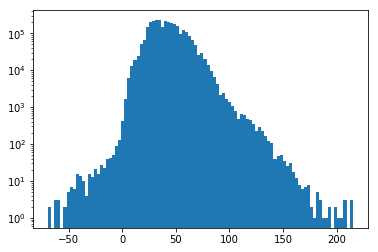

In [134]:
ages = cast['Age'].values
plt.hist(ages[~np.isnan(ages)], bins=100);
plt.yscale('log', nonposy='clip')

In [135]:
cast_ages = cast.groupby(['tconst'])['Age'].agg([np.nanmedian, cast_count])
cast_ages = cast_ages.rename(columns={'nanmedian': 'custom_median'})

In [136]:
cast_ages.head()

,custom_median,cast_count
tconst,,
tt0000009,19.0,3.0
tt0000147,39.0,5.0
tt0000335,11.0,2.0
tt0000502,NaN,0.0
tt0000574,28.0,6.0


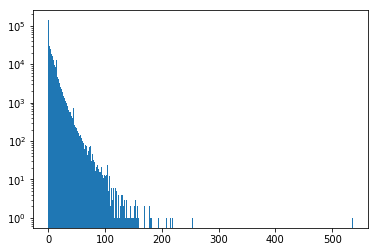

In [137]:
plt.hist(cast_ages['cast_count'], bins=500);
plt.yscale('log', nonposy='clip')

We only take the information if we have more than 10 persons in the cast

In [138]:
cast_ages['credible_median'] = np.where(cast_ages['cast_count'] > 10, cast_ages['custom_median'], np.nan)

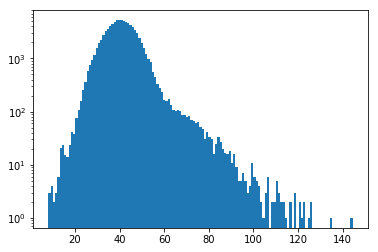

In [139]:
credible_median_ages = cast_ages['credible_median'].values
plt.hist(credible_median_ages[~np.isnan(credible_median_ages)], bins = 135);
plt.yscale('log', nonposy='clip')

We see that we do not have the negative age outliers but we still have suspiciously high values

In [140]:
cast_ages.nlargest(10, 'credible_median')

,custom_median,cast_count,credible_median
tconst,,,
tt6454944,144.5,30.0,144.5
tt6490038,135.0,11.0,135.0
tt1646939,126.0,11.0,126.0
tt3587202,126.0,17.0,126.0
tt0212457,125.0,11.0,125.0
tt3188516,123.0,13.0,123.0
tt3526810,123.0,13.0,123.0
tt10443162,122.0,43.0,122.0
tt2161168,121.0,20.0,121.0


The high values come from recent documentaries using archive footage or reconstruction of very old films.

In [141]:
cast_ages.nsmallest(10, 'credible_median')

,custom_median,cast_count,credible_median
tconst,,,
tt0201347,8.0,27.0,8.0
tt0008144,9.0,17.0,9.0
tt0110366,9.0,34.0,9.0
tt0007617,9.5,14.0,9.5
tt0009721,9.5,14.0,9.5
tt0117008,10.0,44.0,10.0
tt0124879,10.0,35.0,10.0
tt0007669,11.0,14.0,11.0
tt0022397,11.0,16.0,11.0


Legit values

# Creation of success metrics

### Recognition 

In [142]:
OSCAR_WEIGHT = 10
WIN_WEIGHT = 2
NOMINATION_WEIGHT = 1
movies['recognition'] = (movies.oscarWins * OSCAR_WEIGHT) + (movies.nominations * NOMINATION_WEIGHT) \
                        + (movies.wins * WIN_WEIGHT)
recognized_movies = movies.sort_values('recognition', ascending=False)
recognized_movies.head()

,tconst,stars,oscarWins,nominations,wins,releaseDate,releaseCountry,plotKeywords,budget,worldwideGross,...,musicProducer,primaryTitle,originalTitle,isAdult,startYear,runtimeMinutes,genres,testYear,Year,recognition
137270,tt2024544,"[nm0252230, nm0931324, nm1055413]",3,330,238,2014-02-20,Netherlands,"[torture, kidnapping, racism, whipping, slaver...","$20,000,000","$187,733,202",...,nm0001877,12 Years a Slave,12 Years a Slave,0.0,2013.0,134.0,NaN,2014.0,2013.0,836
532918,tt3783958,"[nm0331516, nm1297015, nm1679669]",6,268,233,2016-12-25,USA,"[los angeles california, pianist, aspiring act...","$30,000,000","$446,092,357",...,nm3225654,La La Land,La La Land,0.0,2016.0,128.0,NaN,2016.0,2016.0,794
523662,tt4975722,"[nm0991810, nm0365140, nm5218990]",3,281,223,2016-11-18,USA,"[bullying, gay lead character, african america...","$4,000,000","$65,046,687",...,nm1615109,Moonlight,Moonlight,0.0,2016.0,111.0,NaN,2016.0,2016.0,757
9395,tt1392190,"[nm0362766, nm0000234, nm0396558]",6,220,232,2015-05-14,Netherlands,"[post apocalypse, desert, chase, female warrio...","$150,000,000","$375,209,362",...,nm0432725,Mad Max: Fury Road,Mad Max: Fury Road,0.0,2015.0,120.0,NaN,2015.0,2015.0,744
125615,tt1454468,"[nm0000113, nm0000123, nm0000438]",7,177,233,2013-10-23,France,"[female protagonist, space station, sole survi...","$100,000,000","$723,192,705",...,nm1888527,Gravity,Gravity,0.0,2013.0,91.0,NaN,2013.0,2013.0,713


In [143]:
recognized_movies = recognized_movies.merge(cast_ages, how='left', left_on='tconst', right_index=True)
recognized_movies = recognized_movies.drop_duplicates(subset=['tconst'])
recognized_movies.head()

,tconst,stars,oscarWins,nominations,wins,releaseDate,releaseCountry,plotKeywords,budget,worldwideGross,...,isAdult,startYear,runtimeMinutes,genres,testYear,Year,recognition,custom_median,cast_count,credible_median
137270,tt2024544,"[nm0252230, nm0931324, nm1055413]",3,330,238,2014-02-20,Netherlands,"[torture, kidnapping, racism, whipping, slaver...","$20,000,000","$187,733,202",...,0.0,2013.0,134.0,NaN,2014.0,2013.0,836,42.5,32.0,42.5
532918,tt3783958,"[nm0331516, nm1297015, nm1679669]",6,268,233,2016-12-25,USA,"[los angeles california, pianist, aspiring act...","$30,000,000","$446,092,357",...,0.0,2016.0,128.0,NaN,2016.0,2016.0,794,36.5,54.0,36.5
523662,tt4975722,"[nm0991810, nm0365140, nm5218990]",3,281,223,2016-11-18,USA,"[bullying, gay lead character, african america...","$4,000,000","$65,046,687",...,0.0,2016.0,111.0,NaN,2016.0,2016.0,757,37.0,5.0,NaN
9395,tt1392190,"[nm0362766, nm0000234, nm0396558]",6,220,232,2015-05-14,Netherlands,"[post apocalypse, desert, chase, female warrio...","$150,000,000","$375,209,362",...,0.0,2015.0,120.0,NaN,2015.0,2015.0,744,40.0,25.0,40.0
125615,tt1454468,"[nm0000113, nm0000123, nm0000438]",7,177,233,2013-10-23,France,"[female protagonist, space station, sole survi...","$100,000,000","$723,192,705",...,0.0,2013.0,91.0,NaN,2013.0,2013.0,713,53.0,4.0,NaN


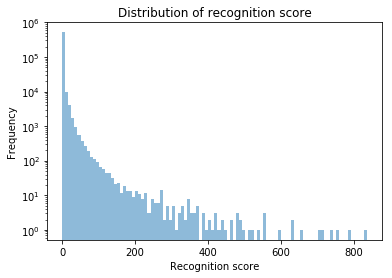

In [144]:
fig, ax = plt.subplots()
recognized_movies.recognition.plot.hist(ax=ax, bins=100, alpha=0.5)
ax.set_yscale('log')
ax.set_title('Distribution of recognition score')
ax.set_xlabel('Recognition score');

### Popularity  

We directly use the number of votes form the imdb website, we got it from ratings file from imdb

In [145]:
recognized_movies = recognized_movies.merge(movie_ratings, on='tconst', how='left')

### Revenue

We only use the revenue expressed in US dollars (the majority) as it is hard to find conversion rates before 2000. We use the easymoney library to take into account the inflation.

In [146]:
recognized_movies['worldwideGross_adjusted'] = recognized_movies['worldwideGross'].apply(keep_numbers)
ep = EasyPeasy()
recognized_movies['worldwideGross_adjusted'] = normalize_inflation(recognized_movies['worldwideGross_adjusted'],\
                                                                   recognized_movies['Year'])

recognized_movies['budget_adjusted'] = recognized_movies['budget'].apply(keep_numbers)
recognized_movies['budget_adjusted'] = normalize_inflation(recognized_movies['budget_adjusted'],\
                                                                   recognized_movies['Year'])

## Comparing the three success metrics with the median age of the cast 

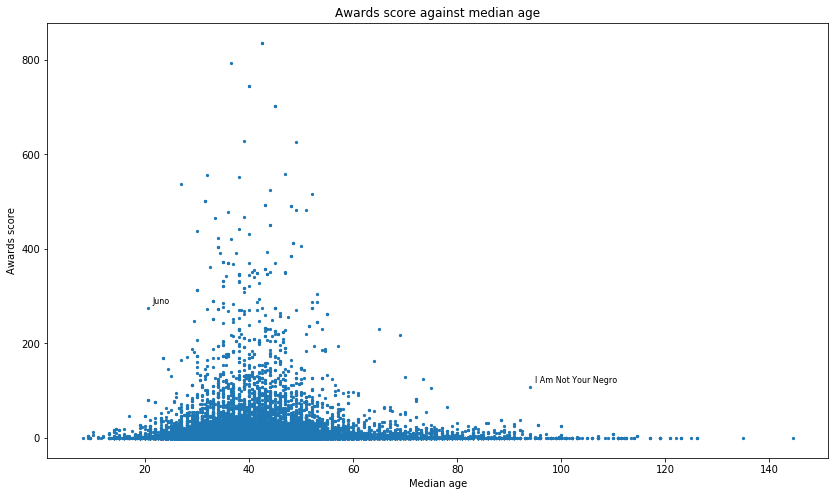

In [31]:
fig = plt.figure(figsize=(14,8))

plt.scatter(recognized_movies['credible_median'],\
            recognized_movies['recognition'], s=5);
plt.title("Awards score against median age") 

annotations = []
annotations.append(recognized_movies[(recognized_movies['credible_median'] < 25) &\
                  (recognized_movies['recognition'] > 200)]\
                 [['primaryTitle', 'credible_median', 'recognition']].values[0])
annotations.append(recognized_movies[(recognized_movies['credible_median'] > 90) &\
                  (recognized_movies['recognition'] > 100)]\
                 [['primaryTitle', 'credible_median', 'recognition']].values[0])

for title, x, y in annotations:
    plt.text(x+1, y+10, title, fontsize=8)

#plt.yscale('symlog')
plt.xlabel('Median age')
plt.ylabel('Awards score');

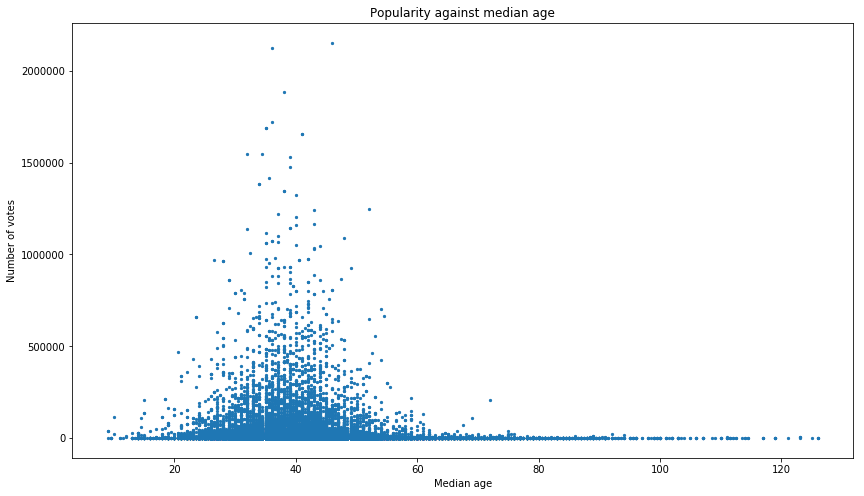

In [32]:
fig = plt.figure(figsize=(14,8))

plt.scatter(recognized_movies['credible_median'],\
            recognized_movies['numVotes'], s=5);

plt.title("Popularity against median age")  
#plt.yscale('symlog')
plt.xlabel('Median age')
plt.ylabel('Number of votes');

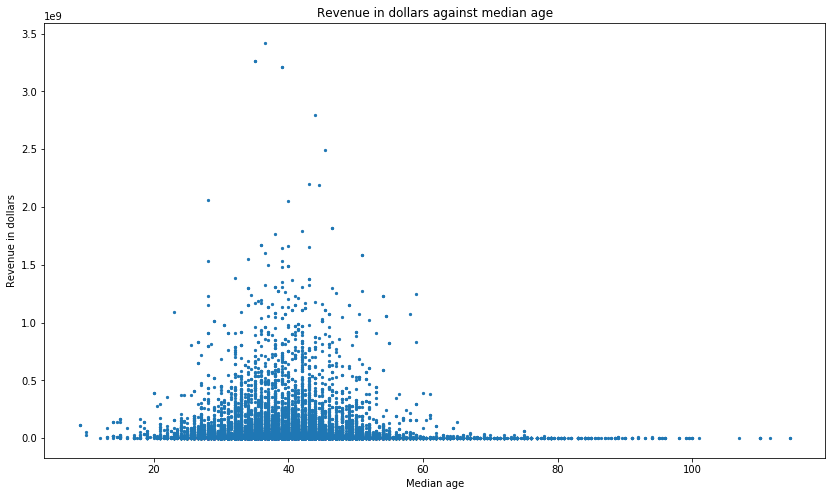

In [33]:
fig = plt.figure(figsize=(14,8))

plt.scatter(recognized_movies['credible_median'],\
            recognized_movies['worldwideGross_adjusted'], s=5);

plt.title("Revenue in dollars against median age")
#plt.yscale('symlog')
plt.xlabel('Median age')
plt.ylabel('Revenue in dollars');

# Trying to go more in-depth with more statistics for some age intervals

In [34]:
intervals = np.arange(20, 90, 10)
intervals = np.insert(intervals, 0, 0)
intervals = np.insert(intervals, len(intervals), 150)
movies_stats = recognized_movies.groupby(pd.cut(recognized_movies['credible_median'], intervals))\
               ['recognition', 'numVotes', 'worldwideGross_adjusted']\
                 .agg([cast_count, np.nanmean, np.nanstd, np.nanmin, np.nanmax, np.nanmedian, \
                       lambda x: bootstrap_mean_ci(x, 5, 1000), lambda x: bootstrap_median_ci(x, 5, 1000),\
                       lambda x: np.nanpercentile(x, q = 75), lambda x: np.nanpercentile(x, q = 90),\
                       lambda x: np.nanpercentile(x, q = 95), lambda x: np.nanpercentile(x, q = 99)])

movies_stats = movies_stats.rename(columns={'<lambda_0>': '95% CI mean', '<lambda_1>': '95% CI median',\
                                '<lambda_2>': '75%','<lambda_3>': '90%', '<lambda_4>': '95%','<lambda_5>': '99%'})

In [35]:
movies_stats['recognition']

,cast_count,nanmean,nanstd,nanmin,nanmax,nanmedian,95% CI mean,95% CI median,75%,90%,95%,99%
credible_median,,,,,,,,,,,,
"(0, 20]",248,3.076613,7.154044,0,47,0,"[2.379, 3.863]","[0.0, 0.0]",3,9,17.00,37.54
"(20, 30]",7488,3.264824,15.213295,0,538,0,"[3.005, 3.564]","[0.0, 0.0]",0,8,16.65,51.00
"(30, 40]",47526,3.490489,18.398615,0,794,0,"[3.353, 3.63]","[0.0, 0.0]",0,8,16.00,59.00
"(40, 50]",49064,3.274927,18.096975,0,836,0,"[3.147, 3.422]","[0.0, 0.0]",0,6,15.00,60.00
"(50, 60]",8437,3.637075,17.053491,0,517,0,"[3.348, 3.925]","[0.0, 0.0]",0,8,17.00,66.00
"(60, 70]",1438,3.376912,12.990862,0,230,0,"[2.849, 3.94]","[0.0, 0.0]",0,9,17.00,56.26
"(70, 80]",711,3.326301,10.140999,0,125,0,"[2.74, 3.918]","[0.0, 0.0]",2,10,16.50,45.00
"(80, 150]",427,2.915691,8.218404,0,108,0,"[2.314, 3.593]","[0.0, 0.0]",2,10,17.70,31.74


In [36]:
movies_stats['numVotes']

,cast_count,nanmean,nanstd,nanmin,nanmax,nanmedian,95% CI mean,95% CI median,75%,90%,95%,99%
credible_median,,,,,,,,,,,,
"(0, 20]",233.0,14598.343348,38146.476922,7.0,214105.0,519.0,"[10842.366, 18695.644]","[343.0, 634.0]",4579.0,40406.0,115313.40,191038.96
"(20, 30]",6776.0,10972.907320,51682.137452,5.0,971031.0,226.0,"[9947.982, 11970.618]","[214.0, 247.0]",1978.0,16366.5,46546.25,229226.50
"(30, 40]",42785.0,11070.220381,61724.174596,5.0,2126738.0,174.0,"[10616.691, 11572.39]","[170.0, 179.0]",1218.0,10472.0,43407.40,250970.92
"(40, 50]",44687.0,6999.394320,44176.815964,5.0,2153889.0,137.0,"[6657.863, 7324.802]","[134.0, 140.0]",837.0,5839.0,21045.00,165032.38
"(50, 60]",7732.0,4087.909079,28617.139238,5.0,1245991.0,157.0,"[3564.064, 4663.649]","[148.0, 167.05]",801.0,4175.0,10696.45,94412.62
"(60, 70]",1263.0,1620.030087,7409.416641,5.0,132869.0,111.0,"[1310.816, 1990.387]","[101.0, 128.0]",546.0,2481.0,6373.00,26237.36
"(70, 80]",634.0,1264.307571,8707.124702,5.0,207825.0,106.5,"[817.056, 1923.377]","[91.0, 131.0]",515.0,1838.3,5079.35,18208.00
"(80, 150]",380.0,621.192105,1872.794914,5.0,21967.0,99.0,"[478.49, 782.201]","[76.0, 119.0]",470.0,1427.7,2557.00,10881.59


In [37]:
movies_stats['worldwideGross_adjusted']

,cast_count,nanmean,nanstd,nanmin,nanmax,nanmedian,95% CI mean,95% CI median,75%,90%,95%,99%
credible_median,,,,,,,,,,,,
"(0, 20]",91.0,4.032998e+07,7.000282e+07,33102.56,3.881341e+08,1.221432e+07,"[28646908.482, 53291962.319]","[9334345.81, 15961159.98]",3.533039e+07,1.353178e+08,1.541172e+08,3.881341e+08
"(20, 30]",1956.0,4.027418e+07,1.180451e+08,483.39,2.063267e+09,4.576286e+06,"[36255897.469, 44617311.165]","[4039141.334, 5077778.07]",3.379935e+07,9.271842e+07,1.665044e+08,5.450699e+08
"(30, 40]",10609.0,5.403748e+07,1.579645e+08,0.00,3.421994e+09,4.217037e+06,"[51575849.378, 56581866.805]","[3968840.108, 4465970.66]",3.371477e+07,1.411023e+08,2.769024e+08,7.324322e+08
"(40, 50]",9292.0,4.531767e+07,1.392894e+08,37.32,2.797801e+09,3.271393e+06,"[42886393.63, 47649012.986]","[3081777.34, 3491707.25]",2.321982e+07,1.095509e+08,2.297256e+08,7.440602e+08
"(50, 60]",1894.0,2.935710e+07,1.208058e+08,99.39,1.583122e+09,1.667528e+06,"[25046391.493, 33950608.494]","[1473934.568, 1846747.02]",9.167173e+06,4.369420e+07,1.126804e+08,5.897151e+08
"(60, 70]",381.0,6.575293e+06,2.961579e+07,607.96,3.787216e+08,2.363985e+05,"[4152276.077, 9267375.815]","[180705.77, 333743.115]",1.173752e+06,8.608385e+06,2.197141e+07,1.572534e+08
"(70, 80]",214.0,1.708463e+06,7.154872e+06,35.12,6.509734e+07,1.353597e+05,"[1008823.908, 2514203.189]","[78697.35, 174273.97]",5.569895e+05,2.159030e+06,5.193727e+06,2.936966e+07
"(80, 150]",113.0,7.500236e+05,1.981400e+06,382.91,1.211930e+07,1.131150e+05,"[467409.804, 1075711.056]","[71471.76, 167139.89]",5.148790e+05,1.084341e+06,3.557522e+06,1.171273e+07


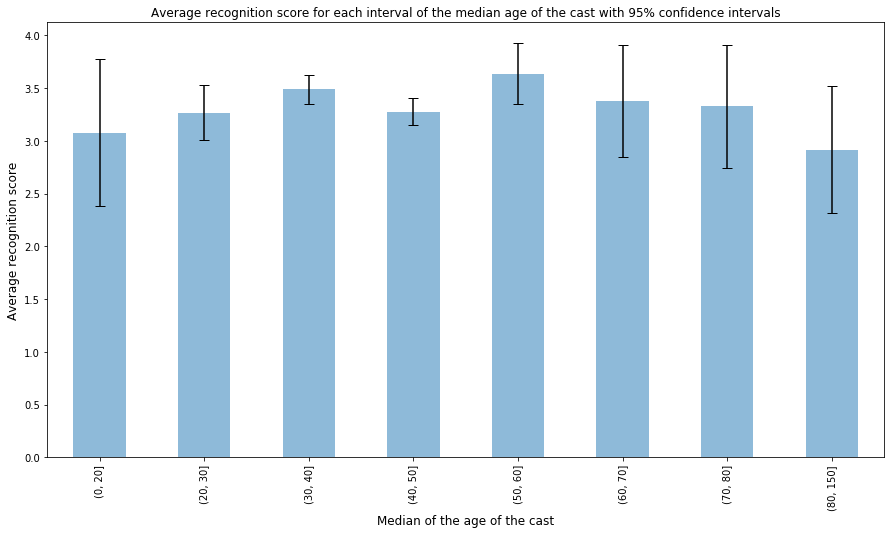

In [38]:
movies_stats_rec = movies_stats['recognition']
movies_stats_rec['errlo']  = movies_stats_rec['nanmean'] - movies_stats_rec['95% CI mean'].apply(lambda x: x[0])

movies_stats_rec['errhi']  = movies_stats_rec['95% CI mean'].apply(lambda x: x[1]) - movies_stats_rec['nanmean']

movies_stats_rec.plot(kind='bar', y='nanmean', yerr=movies_stats_rec[['errlo','errhi']].T.values, \
                      alpha=0.5, capsize=5, figsize=(15,8), legend=False);

plt.xlabel("Median of the age of the cast", size='large')
plt.ylabel("Average recognition score", size="large")
plt.title("Average recognition score for each interval of the median age of the cast with 95% confidence" +\
          " intervals" , size="large");

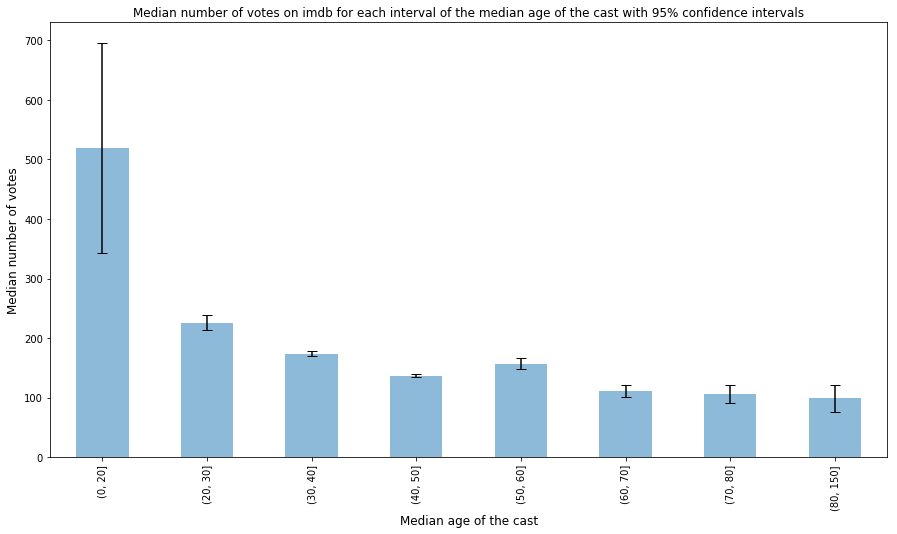

In [39]:
movies_stats_vot = movies_stats['numVotes']
movies_stats_vot['errlo']  = movies_stats_vot['nanmedian'] - movies_stats_vot['95% CI median'].apply(lambda x: x[0])

movies_stats_vot['errhi']  = movies_stats_vot['95% CI median'].apply(lambda x: x[1]) - movies_stats_vot['nanmedian']

movies_stats_vot.plot(kind='bar', y='nanmedian', yerr=movies_stats_vot[['errlo','errhi']].T.values, \
                      alpha=0.5, capsize=5, figsize=(15,8), legend=False);

plt.xlabel("Median age of the cast", size='large')
plt.ylabel("Median number of votes", size="large")
plt.title("Median number of votes on imdb for each interval of the median age of the" \
          " cast with 95% confidence intervals", size="large");

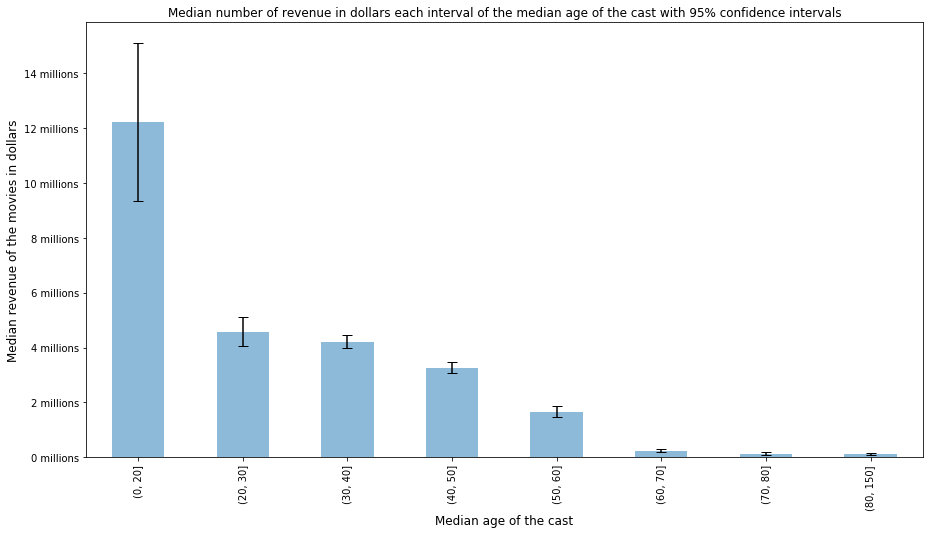

In [40]:
movies_stats_wor = movies_stats['worldwideGross_adjusted']
movies_stats_wor['errlo']  = movies_stats_wor['nanmedian'] - \
                             movies_stats_wor['95% CI median'].apply(lambda x: x[0])

movies_stats_wor['errhi']  = movies_stats_wor['95% CI median'].apply(lambda x: x[1]) - \
                             movies_stats_wor['nanmedian']

g = movies_stats_wor.plot(kind='bar', y='nanmedian', yerr=movies_stats_wor[['errlo','errhi']].T.values, \
                      alpha=0.5, capsize=5, figsize=(15,8), legend=False);

plt.xlabel("Median age of the cast", size='large')
plt.ylabel("Median revenue of the movies in dollars", size="large")
plt.title("Median number of revenue in dollars each interval of the median age of the cast with 95%" + \
          " confidence intervals", size="large");

ylabels = ['{:,.0f}'.format(x) + ' millions' for x in g.get_yticks()/1000000]
g.set_yticklabels(ylabels);

# Metacritic score

In [41]:
clean_metascore = [lambda x: np.nan if x == None else int(x)]
recognized_movies['metascore'] = recognized_movies['metascore'].apply(clean_metascore)

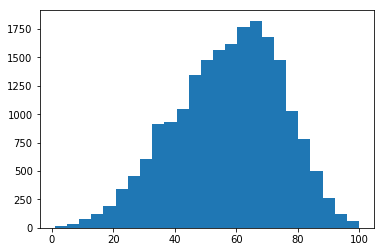

In [42]:
plt.hist(recognized_movies['metascore'], bins = 25);

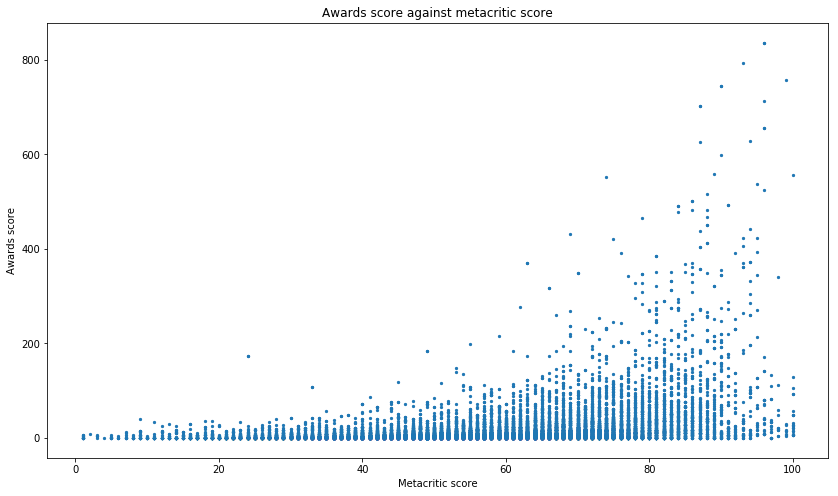

In [43]:
fig = plt.figure(figsize=(14,8))

plt.scatter(recognized_movies['metascore'],\
            recognized_movies['recognition'], s=5);
plt.title("Awards score against metacritic score")   
#plt.yscale('symlog')
plt.xlabel('Metacritic score')
plt.ylabel('Awards score');

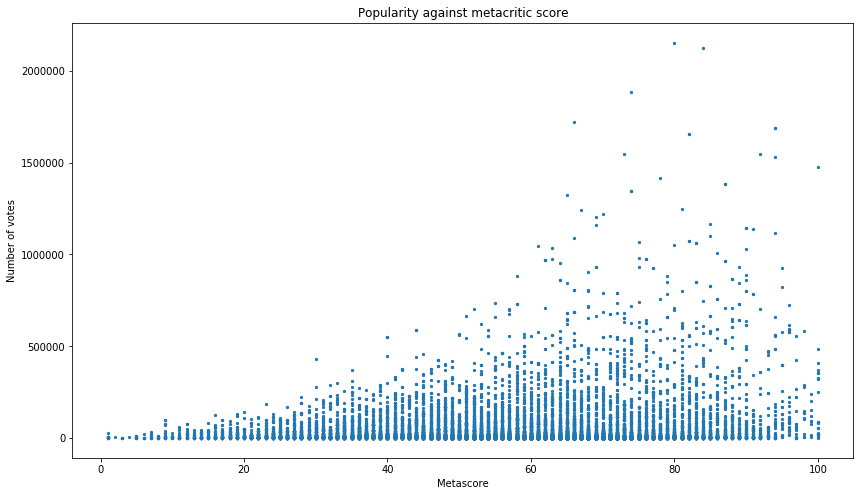

In [44]:
fig = plt.figure(figsize=(14,8))

plt.scatter(recognized_movies['metascore'],\
            recognized_movies['numVotes'], s=5);

plt.title("Popularity against metacritic score")  
#plt.yscale('symlog')
plt.xlabel('Metascore')
plt.ylabel('Number of votes');

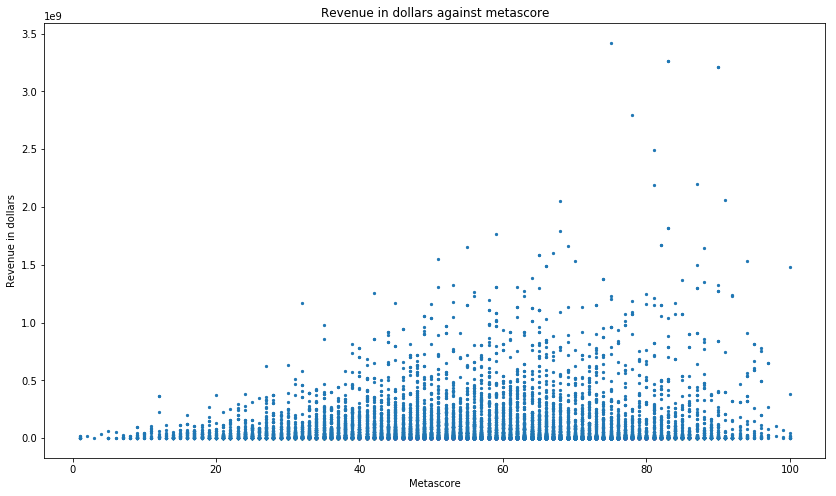

In [45]:
fig = plt.figure(figsize=(14,8))

plt.scatter(recognized_movies['metascore'],\
            recognized_movies['worldwideGross_adjusted'], s=5);

plt.title("Revenue in dollars against metascore")
#plt.yscale('symlog')
plt.xlabel('Metascore')
plt.ylabel('Revenue in dollars');

# isAdult

In [46]:
recognized_movies.groupby('isAdult')['recognition', 'numVotes', 'worldwideGross_adjusted']\
                 .agg([cast_count, np.nanmean, np.nanmedian])

recognition                       numVotes                         \
         cast_count   nanmean nanmedian cast_count      nanmean nanmedian   
isAdult                                                                     
0.0          596696  1.333518         0   307397.0  3278.444149      48.0   
1.0            9886  0.143739         0     5205.0    39.898367      15.0   

        worldwideGross_adjusted                            
                     cast_count       nanmean   nanmedian  
isAdult                                                    
0.0                     55326.0  2.233228e+07  528639.015  
1.0                        10.0  7.771885e+04   43089.960

# runtimeMinutes

In [47]:
length_success = recognized_movies[['tconst', 'primaryTitle', 'runtimeMinutes', 'recognition', \
                                    'numVotes', 'worldwideGross_adjusted']]

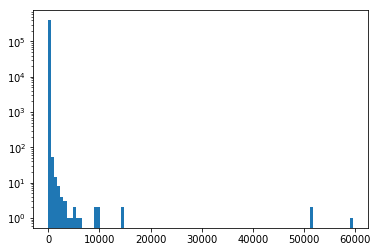

In [48]:
plt.hist(length_success['runtimeMinutes'], bins = 100);
plt.yscale('log', nonposy='clip')

In [49]:
length_success.nlargest(10, 'runtimeMinutes')[['tconst','primaryTitle', 'runtimeMinutes']]

,tconst,primaryTitle,runtimeMinutes
399886,tt10844584,100,59460.0
100142,tt8273150,Logistics,51420.0
100143,tt8273150,Logistics,51420.0
377635,tt2659636,Modern Times Forever,14400.0
377636,tt2659636,Modern Times Forever,14400.0
399880,tt10844900,Qw,10062.0
399881,tt10844900,Qw,10062.0
339117,tt2355497,Beijing 2003,9000.0
339118,tt2355497,Beijing 2003,9000.0
106922,tt5068890,Hunger!,6000.0


Even if the values are legit, we focus on the more conventional lengths

In [50]:
length_success = length_success[length_success['runtimeMinutes'] < 250]

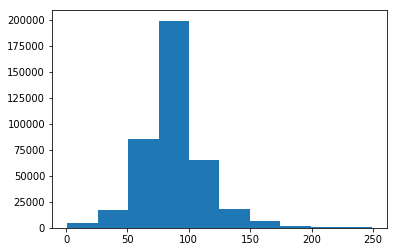

In [51]:
plt.hist(length_success['runtimeMinutes']);
#plt.yscale('log', nonposy='clip')

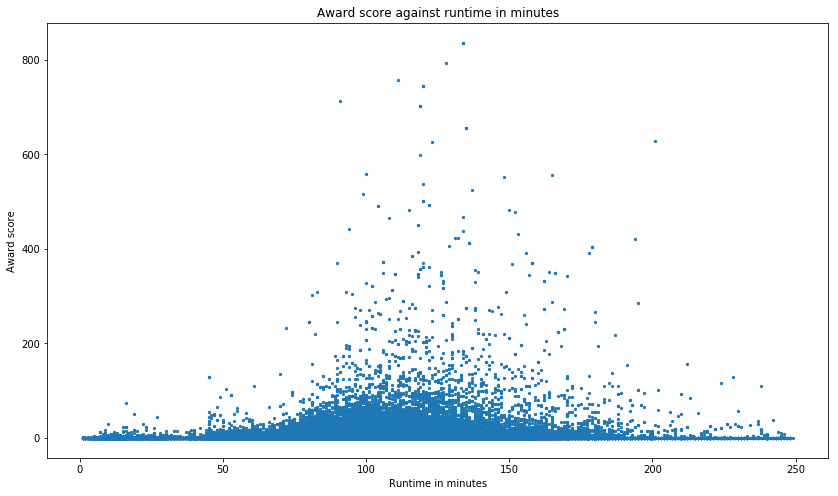

In [52]:
fig = plt.figure(figsize=(14,8))

plt.scatter(length_success['runtimeMinutes'],\
            length_success['recognition'], s=5);

plt.title("Award score against runtime in minutes")
#plt.yscale('symlog')
plt.xlabel('Runtime in minutes')
plt.ylabel('Award score');

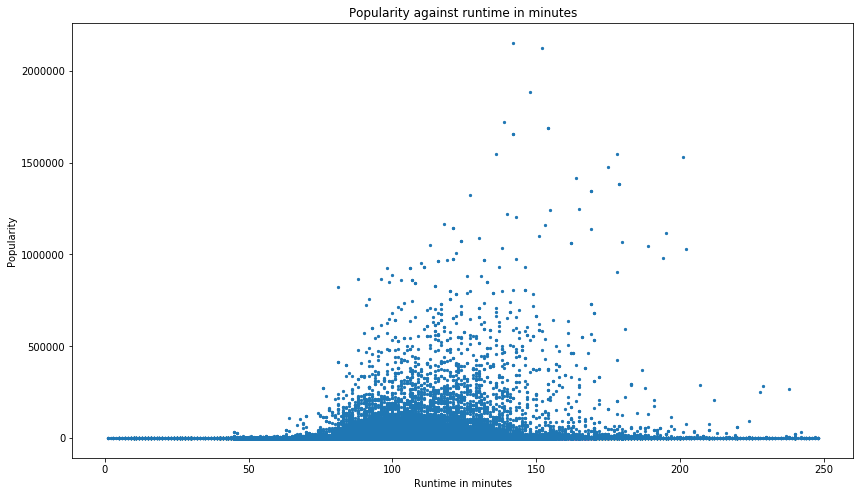

In [53]:
fig = plt.figure(figsize=(14,8))

plt.scatter(length_success['runtimeMinutes'],\
            length_success['numVotes'], s=5);

plt.title("Popularity against runtime in minutes")
#plt.yscale('symlog')
plt.xlabel('Runtime in minutes')
plt.ylabel('Popularity');

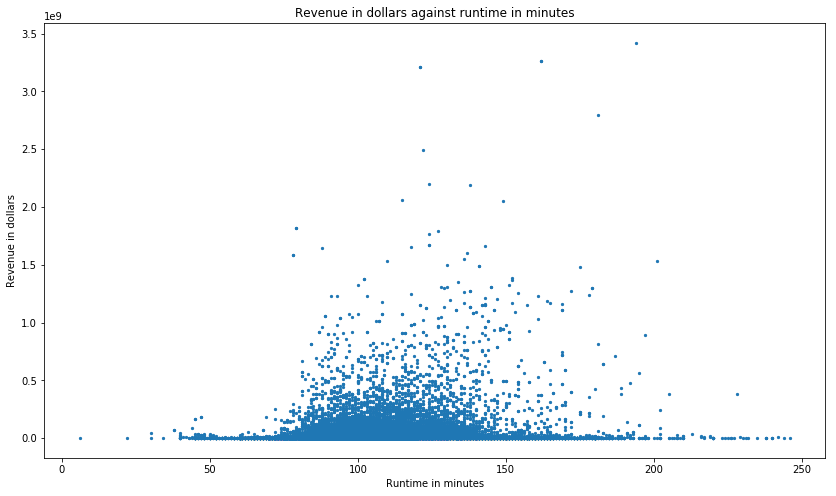

In [54]:
fig = plt.figure(figsize=(14,8))

plt.scatter(length_success['runtimeMinutes'],\
            length_success['worldwideGross_adjusted'], s=5);

plt.title("Revenue in dollars against runtime in minutes")
#plt.yscale('symlog')
plt.xlabel('Runtime in minutes')
plt.ylabel('Revenue in dollars');

# Trying to go more in-depth with more statistics for some runTime intervals

In [55]:
intervals = np.arange(50, 225, 25)
intervals = np.insert(intervals, 0, 0)
intervals = np.insert(intervals, len(intervals), 250)
movies_stats_runtime = recognized_movies.groupby(pd.cut(recognized_movies['runtimeMinutes'], intervals))\
               ['recognition', 'numVotes', 'worldwideGross_adjusted']\
                 .agg([cast_count, np.nanmean, np.nanstd, np.nanmin, np.nanmax, np.nanmedian, \
                       lambda x: bootstrap_mean_ci(x, 5, 1000), lambda x: bootstrap_median_ci(x, 5, 1000),\
                       lambda x: np.nanpercentile(x, q = 75), lambda x: np.nanpercentile(x, q = 90),\
                       lambda x: np.nanpercentile(x, q = 95), lambda x: np.nanpercentile(x, q = 99)])

movies_stats_runtime = movies_stats_runtime.rename(columns={'<lambda_0>': '95% CI mean', \
'<lambda_1>': '95% CI median', '<lambda_2>': '75%','<lambda_3>': '90%', '<lambda_4>': '95%','<lambda_5>': '99%'})

In [56]:
movies_stats_runtime['recognition']

,cast_count,nanmean,nanstd,nanmin,nanmax,nanmedian,95% CI mean,95% CI median,75%,90%,95%,99%
runtimeMinutes,,,,,,,,,,,,
"(0, 50]",22105,0.214703,2.347185,0,130,0,"[0.19, 0.242]","[0.0, 0.0]",0,0,0.0,6.00
"(50, 75]",85078,0.331249,2.380787,0,232,0,"[0.318, 0.345]","[0.0, 0.0]",0,0,0.0,9.00
"(75, 100]",199427,1.497149,6.988321,0,713,0,"[1.472, 1.522]","[0.0, 0.0]",0,4,9.0,26.00
"(100, 125]",66825,4.367467,17.748371,0,757,0,"[4.25, 4.481]","[0.0, 0.0]",2,12,22.0,61.00
"(125, 150]",17929,5.739919,26.206637,0,836,0,"[5.4, 6.082]","[0.0, 0.0]",0,13,28.0,100.00
"(150, 175]",5854,5.779467,27.200348,0,556,0,"[5.215, 6.394]","[0.0, 0.0]",0,11,24.0,110.00
"(175, 200]",1544,6.511658,28.735996,0,420,0,"[5.298, 7.799]","[0.0, 0.0]",0,14,31.0,105.99
"(200, 250]",747,4.200803,26.597584,0,628,0,"[2.812, 6.11]","[0.0, 0.0]",0,6,21.4,89.32


In [57]:
movies_stats_runtime['numVotes']

,cast_count,nanmean,nanstd,nanmin,nanmax,nanmedian,95% CI mean,95% CI median,75%,90%,95%,99%
runtimeMinutes,,,,,,,,,,,,
"(0, 50]",5209.0,97.870417,966.812784,5.0,34937.0,14.0,"[78.71, 121.657]","[13.0, 14.0]",31.00,95.0,209.0,1148.36
"(50, 75]",41842.0,184.897519,2034.536479,5.0,134792.0,22.0,"[169.022, 203.364]","[22.0, 22.0]",67.00,213.0,472.0,2205.00
"(75, 100]",152834.0,1831.488694,15153.738001,5.0,928857.0,63.0,"[1770.591, 1895.893]","[62.0, 63.0]",292.00,1350.0,3856.0,38286.23
"(100, 125]",54797.0,7956.857729,44200.350275,5.0,1166368.0,153.0,"[7653.881, 8268.579]","[149.0, 156.0]",972.00,7266.0,28104.2,191947.40
"(125, 150]",14128.0,13967.815898,77278.926779,5.0,2153889.0,136.0,"[12920.999, 15061.24]","[128.475, 142.0]",1080.00,9352.5,48042.0,375064.00
"(150, 175]",4876.0,12957.367104,90911.226354,5.0,2126738.0,164.0,"[10908.171, 15269.497]","[152.0, 180.0]",1093.00,6559.0,20947.5,376742.00
"(175, 200]",1164.0,14479.926976,104186.618009,5.0,1545029.0,111.5,"[9825.62, 20002.489]","[91.0, 132.0]",1100.75,9003.2,29286.7,297046.00
"(200, 250]",539.0,9029.018553,83350.722170,5.0,1529752.0,62.0,"[3978.163, 15957.849]","[54.0, 70.0]",331.00,3106.0,8512.3,231953.58


In [58]:
movies_stats_runtime['worldwideGross_adjusted']

,cast_count,nanmean,nanstd,nanmin,nanmax,nanmedian,95% CI mean,95% CI median,75%,90%,95%,99%
runtimeMinutes,,,,,,,,,,,,
"(0, 50]",112.0,1.474727e+07,3.390249e+07,615.48,1.791959e+08,670241.185,"[9772603.787, 20266821.691]","[275208.77, 2210957.57]",1.632282e+07,3.308944e+07,6.886404e+07,1.771724e+08
"(50, 75]",1579.0,2.320398e+06,1.294966e+07,15.69,2.543084e+08,33190.470,"[1829242.775, 2907501.911]","[28611.0, 39669.864]",5.050440e+05,3.327863e+06,6.722089e+06,5.091327e+07
"(75, 100]",26000.0,1.281151e+07,6.148520e+07,13.77,1.814742e+09,324282.010,"[12236532.998, 13493712.179]","[311617.984, 336988.014]",2.755526e+06,1.974084e+07,5.585787e+07,2.596821e+08
"(100, 125]",17372.0,3.121952e+07,1.063394e+08,0.00,3.213030e+09,1752497.565,"[29940511.316, 32501467.506]","[1669804.188, 1839858.11]",1.369850e+07,7.426208e+07,1.665387e+08,4.938258e+08
"(125, 150]",4041.0,6.455426e+07,1.875108e+08,30.72,2.191172e+09,2346579.520,"[59751719.015, 69442146.021]","[2084054.92, 2701616.167]",2.638386e+07,1.703832e+08,3.737019e+08,1.030798e+09
"(150, 175]",1035.0,6.381000e+07,2.360697e+08,43.03,3.265544e+09,754777.550,"[52268636.545, 75725098.881]","[616333.0, 944871.38]",9.076590e+06,1.273384e+08,3.764803e+08,1.171720e+09
"(175, 200]",237.0,7.900650e+07,3.390729e+08,1494.28,3.421994e+09,1489766.620,"[45732226.475, 117749193.997]","[1158170.39, 1842441.585]",9.156066e+06,6.792898e+07,4.406243e+08,1.294937e+09
"(200, 250]",62.0,4.575845e+07,2.052190e+08,305.76,1.529402e+09,360553.840,"[12141335.451, 92608943.143]","[99545.23, 1125559.46]",6.083686e+06,3.065477e+07,2.366334e+08,8.282070e+08


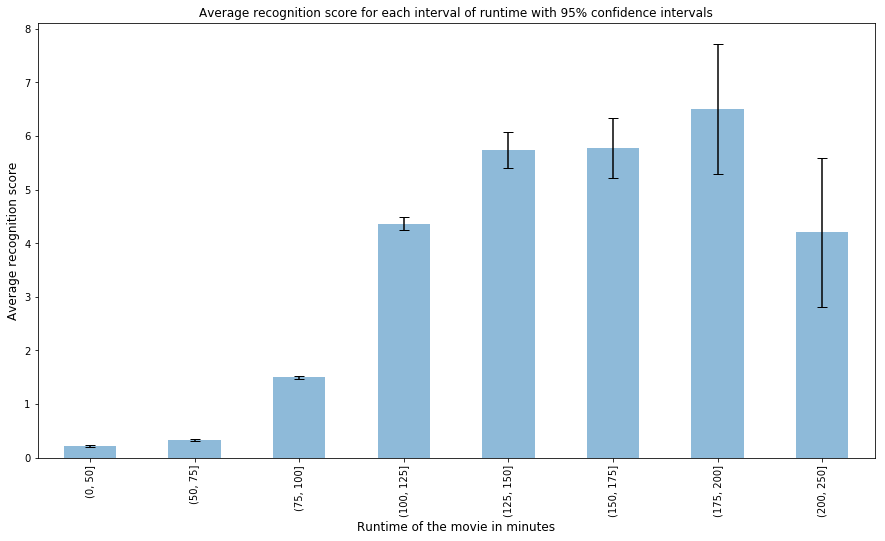

In [59]:
movies_stats_run_rec = movies_stats_runtime['recognition']
movies_stats_run_rec['errlo']  = movies_stats_run_rec['nanmean'] - \
                                 movies_stats_run_rec['95% CI mean'].apply(lambda x: x[0])

movies_stats_run_rec['errhi']  = movies_stats_run_rec['95% CI mean'].apply(lambda x: x[1]) -\
                                 movies_stats_run_rec['nanmean']

movies_stats_run_rec.plot(kind='bar', y='nanmean', yerr=movies_stats_run_rec[['errlo','errhi']].T.values, \
                      alpha=0.5, capsize=5, figsize=(15,8), legend=False);

plt.xlabel("Runtime of the movie in minutes", size='large')
plt.ylabel("Average recognition score", size="large")
plt.title("Average recognition score for each interval of runtime with 95% confidence" +\
          " intervals" , size="large");

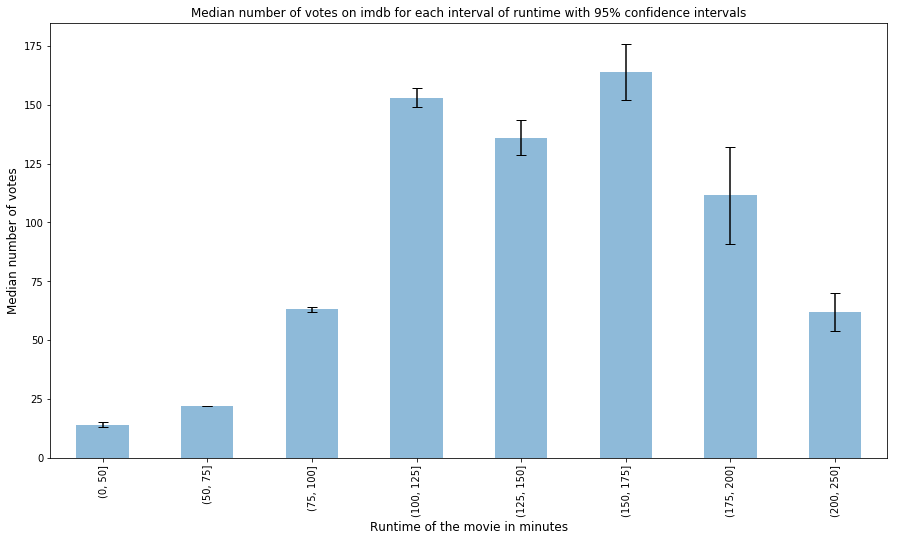

In [60]:
movies_stats_run_vot = movies_stats_runtime['numVotes']
movies_stats_run_vot['errlo']  = movies_stats_run_vot['nanmedian'] - \
                                 movies_stats_run_vot['95% CI median'].apply(lambda x: x[0])

movies_stats_run_vot['errhi']  = movies_stats_run_vot['95% CI median'].apply(lambda x: x[1]) -\
                                 movies_stats_run_vot['nanmedian']

movies_stats_run_vot.plot(kind='bar', y='nanmedian', yerr=movies_stats_run_vot[['errlo','errhi']].T.values, \
                      alpha=0.5, capsize=5, figsize=(15,8), legend=False);

plt.xlabel("Runtime of the movie in minutes", size='large')
plt.ylabel("Median number of votes", size="large")
plt.title("Median number of votes on imdb for each interval of runtime with 95% confidence" +\
          " intervals" , size="large");

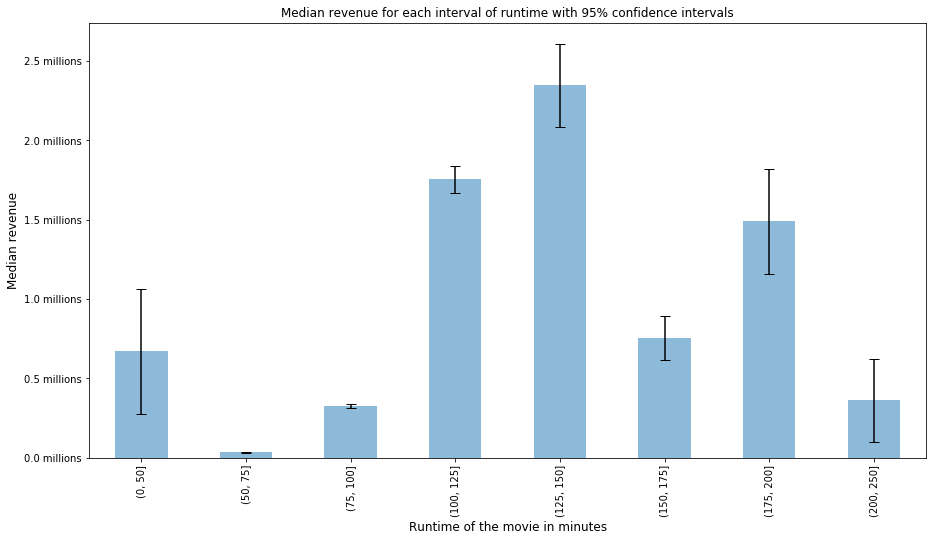

In [61]:
movies_stats_run_wor = movies_stats_runtime['worldwideGross_adjusted']
movies_stats_run_wor['errlo']  = movies_stats_run_wor['nanmedian'] - \
                                 movies_stats_run_wor['95% CI median'].apply(lambda x: x[0])

movies_stats_run_wor['errhi']  = movies_stats_run_wor['95% CI median'].apply(lambda x: x[1]) -\
                                 movies_stats_run_wor['nanmedian']

g = movies_stats_run_wor.plot(kind='bar', y='nanmedian', yerr=movies_stats_run_wor[['errlo','errhi']].T.values, \
                      alpha=0.5, capsize=5, figsize=(15,8), legend=False);

plt.xlabel("Runtime of the movie in minutes", size='large')
plt.ylabel("Median revenue", size="large")
plt.title("Median revenue for each interval of runtime with 95% confidence" +\
          " intervals" , size="large");
ylabels = ['{:,.1f}'.format(x) + ' millions' for x in g.get_yticks()/1000000]
g.set_yticklabels(ylabels);

In [62]:
movies_stats_run_wor

,cast_count,nanmean,nanstd,nanmin,nanmax,nanmedian,95% CI mean,95% CI median,75%,90%,95%,99%,errlo,errhi
runtimeMinutes,,,,,,,,,,,,,,
"(0, 50]",112.0,1.474727e+07,3.390249e+07,615.48,1.791959e+08,670241.185,"[9772603.787, 20266821.691]","[275208.77, 2210957.57]",1.632282e+07,3.308944e+07,6.886404e+07,1.771724e+08,395032.415,1540716.385
"(50, 75]",1579.0,2.320398e+06,1.294966e+07,15.69,2.543084e+08,33190.470,"[1829242.775, 2907501.911]","[28611.0, 39669.864]",5.050440e+05,3.327863e+06,6.722089e+06,5.091327e+07,4579.470,6479.394
"(75, 100]",26000.0,1.281151e+07,6.148520e+07,13.77,1.814742e+09,324282.010,"[12236532.998, 13493712.179]","[311617.984, 336988.014]",2.755526e+06,1.974084e+07,5.585787e+07,2.596821e+08,12664.026,12706.004
"(100, 125]",17372.0,3.121952e+07,1.063394e+08,0.00,3.213030e+09,1752497.565,"[29940511.316, 32501467.506]","[1669804.188, 1839858.11]",1.369850e+07,7.426208e+07,1.665387e+08,4.938258e+08,82693.377,87360.545
"(125, 150]",4041.0,6.455426e+07,1.875108e+08,30.72,2.191172e+09,2346579.520,"[59751719.015, 69442146.021]","[2084054.92, 2701616.167]",2.638386e+07,1.703832e+08,3.737019e+08,1.030798e+09,262524.600,355036.647
"(150, 175]",1035.0,6.381000e+07,2.360697e+08,43.03,3.265544e+09,754777.550,"[52268636.545, 75725098.881]","[616333.0, 944871.38]",9.076590e+06,1.273384e+08,3.764803e+08,1.171720e+09,138444.550,190093.830
"(175, 200]",237.0,7.900650e+07,3.390729e+08,1494.28,3.421994e+09,1489766.620,"[45732226.475, 117749193.997]","[1158170.39, 1842441.585]",9.156066e+06,6.792898e+07,4.406243e+08,1.294937e+09,331596.230,352674.965
"(200, 250]",62.0,4.575845e+07,2.052190e+08,305.76,1.529402e+09,360553.840,"[12141335.451, 92608943.143]","[99545.23, 1125559.46]",6.083686e+06,3.065477e+07,2.366334e+08,8.282070e+08,261008.610,765005.620


# plotKeywords

Instead of doing statistics for each keywords, we get the top 1000 of movies in term of recognition, number of votes and revenue and compare the keywords of those movies with the other ones.

Because of the explicit nature of the adult movies plot keywords, we only take into account the family-friendly movies in this section.

In [63]:
top_n = 10000
recognized_movies_christian = recognized_movies[recognized_movies['isAdult'] == 0.0]
top_recognition = recognized_movies_christian.sort_values('recognition', ascending=False).head(top_n)
top_numVotes = recognized_movies_christian.sort_values('numVotes', ascending=False).head(top_n)
top_revenue = recognized_movies_christian.sort_values('worldwideGross_adjusted', ascending=False).head(top_n)

In [64]:
#We just take the oscarWins because we only want one column, it has nothing to do with the oscarWins
top_reco_keywords = top_recognition.explode('plotKeywords').groupby('plotKeywords').agg([cast_count])['oscarWins']
top_numV_keywords = top_numVotes.explode('plotKeywords').groupby('plotKeywords').agg([cast_count])['oscarWins']
top_rev_keywords = top_revenue.explode('plotKeywords').groupby('plotKeywords').agg([cast_count])['oscarWins']

KeyboardInterrupt: 

In [ ]:
top_reco_keywords = top_reco_keywords.sort_values(by='cast_count', ascending=False).head(20)
top_reco_keywords['top_rank'] = top_reco_keywords['cast_count'].rank(ascending=False, method='dense')
top_reco_keywords = top_reco_keywords.reset_index()

In [ ]:
top_numV_keywords = top_numV_keywords.sort_values(by='cast_count', ascending=False).head(20)
top_numV_keywords['top_rank'] = top_numV_keywords['cast_count'].rank(ascending=False, method='dense')
top_numV_keywords = top_numV_keywords.reset_index()

In [ ]:
top_rev_keywords = top_rev_keywords.sort_values(by='cast_count', ascending=False).head(20)
top_rev_keywords['top_rank'] = top_rev_keywords['cast_count'].rank(ascending=False, method='dense')
top_rev_keywords = top_rev_keywords.reset_index()

In [ ]:
bad_recognition = recognized_movies_christian.sort_values('recognition', ascending=True)\
                 .head(len(recognized_movies)-top_n)

bad_numVotes = recognized_movies_christian.sort_values('numVotes', ascending=True)\
              .head(len(recognized_movies)-top_n)

bad_revenue = recognized_movies_christian.sort_values('worldwideGross_adjusted', ascending=True)\
             .head(len(recognized_movies)-top_n)

In [ ]:
#We just take the oscarWins because we only want one column, it has nothing to do with the oscarWins
bad_reco_keywords = bad_recognition.explode('plotKeywords').groupby('plotKeywords').agg([cast_count])['oscarWins']
bad_numV_keywords = bad_numVotes.explode('plotKeywords').groupby('plotKeywords').agg([cast_count])['oscarWins']
bad_rev_keywords = bad_revenue.explode('plotKeywords').groupby('plotKeywords').agg([cast_count])['oscarWins']

In [ ]:
bad_reco_keywords['bad_rank'] = bad_reco_keywords['cast_count'].rank(ascending=False, method='dense')
bad_reco_keywords = bad_reco_keywords.reset_index()

In [ ]:
bad_numV_keywords['bad_rank'] = bad_numV_keywords['cast_count'].rank(ascending=False, method='dense')
bad_numV_keywords = bad_numV_keywords.reset_index()

In [ ]:
bad_rev_keywords['bad_rank'] = bad_rev_keywords['cast_count'].rank(ascending=False, method='dense')
bad_rev_keywords = bad_rev_keywords.reset_index()

In [ ]:
reco_keywords = top_reco_keywords.merge(bad_reco_keywords, how='inner', on='plotKeywords')
reco_keywords['diff'] = reco_keywords['bad_rank'] - reco_keywords['top_rank']
reco_keywords = reco_keywords.sort_values('diff', ascending=False)
reco_keywords = reco_keywords.set_index('plotKeywords')
reco_keywords.plot(kind='bar', y='diff', alpha=0.5, capsize=5, figsize=(15,8), legend=False);

plt.title('Difference in rank in the top {} movies with respect to recognition and the other movies'.format(top_n))
plt.xlabel('Plot keyword')
plt.ylabel('Difference in rank');

In [ ]:
numV_keywords = top_numV_keywords.merge(bad_numV_keywords, how='inner', on='plotKeywords')
numV_keywords['diff'] = numV_keywords['bad_rank'] - numV_keywords['top_rank']
numV_keywords = numV_keywords.sort_values('diff', ascending=False)
numV_keywords = numV_keywords.set_index('plotKeywords')
numV_keywords.plot(kind='bar', y='diff', alpha=0.5, capsize=5, figsize=(15,8), legend=False);

plt.title('Difference in rank in the top {} movies with respect to number of votes on imdb and the other movies'\
          .format(top_n))
plt.xlabel('Plot keyword')
plt.ylabel('Difference in rank');

In [ ]:
rev_keywords = top_rev_keywords.merge(bad_rev_keywords, how='inner', on='plotKeywords')
rev_keywords['diff'] = rev_keywords['bad_rank'] - rev_keywords['top_rank']
rev_keywords = rev_keywords.sort_values('diff', ascending=False)
rev_keywords = rev_keywords.set_index('plotKeywords')
rev_keywords.plot(kind='bar', y='diff', alpha=0.5, capsize=5, figsize=(15,8), legend=False);

plt.title('Difference in rank in the top {} movies with respect to revenue and the other movies'.format(top_n))
plt.xlabel('Plot keyword')
plt.ylabel('Difference in rank');

# Genres

In [ ]:
movies_filtered = pd.read_pickle('pickles/filtered_movies.pkl')
movies_genres = movies_filtered[['tconst', 'genres']]
recognized_movies = recognized_movies.drop(['genres'], axis=1)
recognized_movies = recognized_movies.merge(movies_genres, on='tconst', how='left')
recognized_movies = recognized_movies.replace('\\N', np.nan)
recognized_movies['genres'] = recognized_movies['genres'].apply(split_profession)
recognized_movies

In [ ]:
genres = recognized_movies.explode('genres').groupby('genres')['tconst']\
         .agg({'size': len, 'set': lambda x: set(x)})

In [ ]:
genres

We remove the small set such as Game-show, Short and Talk-show

In [ ]:
genres = genres[genres['size'] > 100].reset_index()

In [ ]:
jaccard = df_crossjoin(genres)

In [ ]:
jaccard['distance'] = np.vectorize(jaccard_similarity)(jaccard['set_x'], jaccard['set_y'])
jaccard = jaccard.drop(['set_x', 'set_y'], axis=1)

In [ ]:
jaccard

In [ ]:
jaccard_pivot = jaccard.pivot(index='genres_x', columns='genres_y', values='distance')
plt.figure(figsize=(13,10))

mask = np.zeros((len(jaccard_pivot), len(jaccard_pivot)))
mask[np.diag_indices(len(jaccard_pivot))] = True

ax = sns.heatmap(jaccard_pivot, mask=mask, fmt="g", cmap='viridis', vmax = 0.13, annot=True)
ax.set_ylim(len(jaccard_pivot)+0.5, -0.5);
ax.set_xlabel('');
ax.set_ylabel('');

In [ ]:
genres_success = recognized_movies.explode('genres').groupby('genres')['recognition', 'numVotes',\
                                                                       'worldwideGross_adjusted']\
                 .agg([cast_count, np.nanmean, np.nanstd, np.nanmin, np.nanmax, np.nanmedian, \
                       lambda x: bootstrap_mean_ci(x, 5, 1000), lambda x: bootstrap_median_ci(x, 5, 1000),\
                       lambda x: np.nanpercentile(x, q = 75), lambda x: np.nanpercentile(x, q = 90),\
                       lambda x: np.nanpercentile(x, q = 95), lambda x: np.nanpercentile(x, q = 99)])

genres_success = genres_success.rename(columns={'<lambda_0>': '95% CI mean', '<lambda_1>': '95% CI median',\
                                '<lambda_2>': '75%','<lambda_3>': '90%', '<lambda_4>': '95%','<lambda_5>': '99%'})

In [ ]:
genres_success['recognition']

In [ ]:
genres_success['numVotes']

In [ ]:
genres_success['worldwideGross_adjusted']

In [ ]:
movies_stats_gen_rec = genres_success[genres_success['recognition']['cast_count'] > 100]['recognition']
movies_stats_gen_rec['errlo']  = movies_stats_gen_rec['nanmean'] - \
                                 movies_stats_gen_rec['95% CI mean'].apply(lambda x: x[0])

movies_stats_gen_rec['errhi']  = movies_stats_gen_rec['95% CI mean'].apply(lambda x: x[1]) -\
                                 movies_stats_gen_rec['nanmean']

movies_stats_gen_rec = movies_stats_gen_rec.sort_values('nanmean', ascending=False)

movies_stats_gen_rec.plot(kind='bar', y='nanmean', yerr=movies_stats_gen_rec[['errlo','errhi']].T.values, \
                      alpha=0.5, capsize=5, figsize=(15,8), legend=False);

plt.xlabel("Genre of the movie", size='large')
plt.ylabel("Average recognition score", size="large")
plt.title("Average recognition score for each movie genre with 95% confidence interval" , size="large");

In [ ]:
movies_stats_gen_vot = genres_success[genres_success['numVotes']['cast_count'] > 100]['numVotes']

movies_stats_gen_vot['errlo']  = movies_stats_gen_vot['nanmedian'] - \
                                 movies_stats_gen_vot['95% CI median'].apply(lambda x: x[0])

movies_stats_gen_vot['errhi']  = movies_stats_gen_vot['95% CI median'].apply(lambda x: x[1]) -\
                                 movies_stats_gen_vot['nanmedian']

movies_stats_gen_vot = movies_stats_gen_vot.sort_values('nanmedian', ascending=False)

movies_stats_gen_vot.plot(kind='bar', y='nanmedian', yerr=movies_stats_gen_vot[['errlo','errhi']].T.values, \
                      alpha=0.5, capsize=5, figsize=(15,8), legend=False);

plt.xlabel("Genre of the movie", size='large')
plt.ylabel("Median number of votes", size="large")
plt.title("Median number of votes for each movie genre with 95% confidence interval" , size="large");

In [ ]:
movies_stats_gen_wor = genres_success[genres_success['worldwideGross_adjusted']['cast_count'] > 100]\
                                                    ['worldwideGross_adjusted']

movies_stats_gen_wor['errlo']  = movies_stats_gen_wor['nanmedian'] - \
                                 movies_stats_gen_wor['95% CI median'].apply(lambda x: x[0])

movies_stats_gen_wor['errhi']  = movies_stats_gen_wor['95% CI median'].apply(lambda x: x[1]) -\
                                 movies_stats_gen_wor['nanmedian']

movies_stats_gen_wor = movies_stats_gen_wor.sort_values('nanmedian', ascending=False)

g = movies_stats_gen_wor.plot(kind='bar', y='nanmedian', yerr=movies_stats_gen_wor[['errlo','errhi']].T.values, \
                      alpha=0.5, capsize=5, figsize=(15,8), legend=False);

ylabels = ['{:,.1f}'.format(x) + ' millions' for x in g.get_yticks()/1000000]
g.set_yticklabels(ylabels);

plt.xlabel("Genre of the movie", size='large')
plt.ylabel("Median revenue", size="large")
plt.title("Median revenue for each movie genre with 95% confidence interval" , size="large");

## Geographical reach

removing rows with \N from the akas dataset as it is just the repetition of the original title

In [147]:
movie_akas = pd.read_csv("data/title.akas.tsv.gz", sep='\t')

In [148]:
country_codes=pd.read_csv('data/countries.csv')

In [279]:
country_codes

,region,country
0,AF,Afghanistan
1,AX,Åland Islands
2,AL,Albania
3,DZ,Algeria
4,AS,American Samoa
...,...,...
246,cshh,Czechoslovakia
247,csxx,Serbia and Montenegro
248,ddde,German Democratic Republic (East Germany)
249,suhh,Soviet Union (USSR)


In [149]:
country_codes.columns=['region','country']

In [150]:
movie_akas=movie_akas.merge(country_codes, how='outer',on='region')

In [151]:
movie_akas.columns = ['tconst' if x=='titleId' else x for x in movie_akas.columns]

movie_akas=movie_akas.drop(movie_akas[movie_akas.region == r'\N'].index,axis=0)

In [152]:
movie_akas.drop('region',axis=1,inplace=True)

looking at the number of unique regions per movie

In [153]:
unique_regions=movie_akas.groupby('tconst').agg({'country': 'nunique'})

unique_regions=unique_regions.reset_index()

unique_regions.columns=['tconst','region']




In [154]:
movies = movies.merge(unique_regions, how='outer', on='tconst')

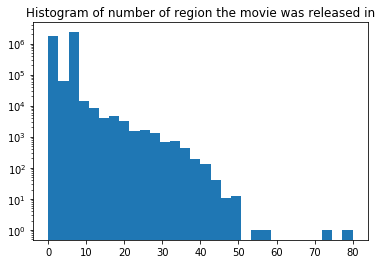

In [155]:
plt.hist(movies['region'], bins=30)
plt.yscale('log')
plt.title('Histogram of number of region the movie was released in')
plt.show()

In [156]:
recognized_movies=recognized_movies.merge(unique_regions, how='outer', on='tconst')

In [157]:
import seaborn as sns


In [196]:
intervals = [0,10,20,30,40,80]
movies_stats_regions = recognized_movies.groupby(pd.cut(recognized_movies['region'], intervals))\
               ['recognition', 'numVotes', 'worldwideGross_adjusted']\
                 .agg([cast_count, np.nanmean, np.nanstd, np.nanmin, np.nanmax, np.nanmedian, \
                       lambda x: bootstrap_mean_ci(x, 5, 1000), lambda x: bootstrap_median_ci(x, 5, 1000),\
                       lambda x: np.nanpercentile(x, q = 75), lambda x: np.nanpercentile(x, q = 90),\
                       lambda x: np.nanpercentile(x, q = 95), lambda x: np.nanpercentile(x, q = 99)])

movies_stats_regions = movies_stats_regions.rename(columns={'<lambda_0>': '95% CI mean', '<lambda_1>': '95% CI median',\
                                '<lambda_2>': '75%','<lambda_3>': '90%', '<lambda_4>': '95%','<lambda_5>': '99%'})

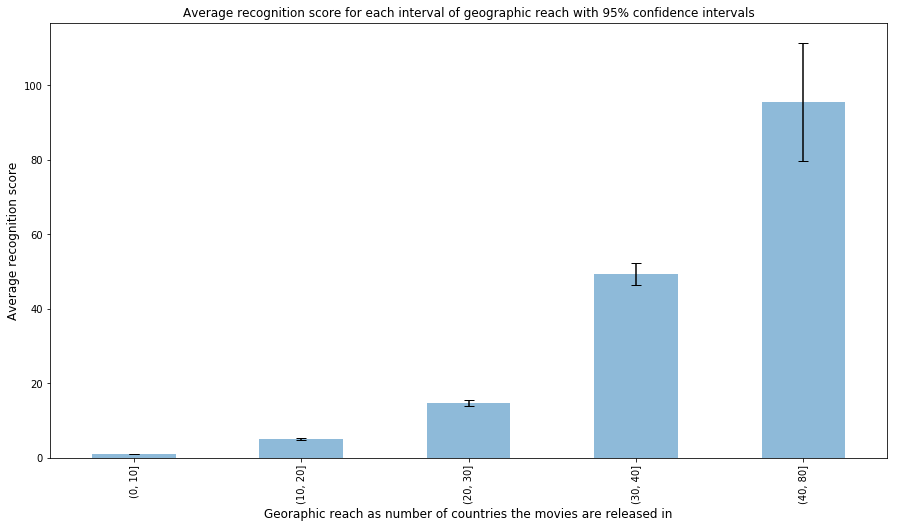

In [198]:
movies_stats_regions_rec = movies_stats_regions['recognition']
movies_stats_regions_rec['errlo']  = movies_stats_regions_rec['nanmean'] - \
                                 movies_stats_regions_rec['95% CI mean'].apply(lambda x: x[0])

movies_stats_regions_rec['errhi']  = movies_stats_regions_rec['95% CI mean'].apply(lambda x: x[1]) -\
                                 movies_stats_regions_rec['nanmean']

movies_stats_regions_rec.plot(kind='bar', y='nanmean', yerr=movies_stats_regions_rec[['errlo','errhi']].T.values, \
                      alpha=0.5, capsize=5, figsize=(15,8), legend=False);

plt.xlabel("Georaphic reach as number of countries the movies are released in", size='large')
plt.ylabel("Average recognition score", size="large")
plt.title("Average recognition score for each interval of geographic reach with 95% confidence" +\
          " intervals" , size="large");

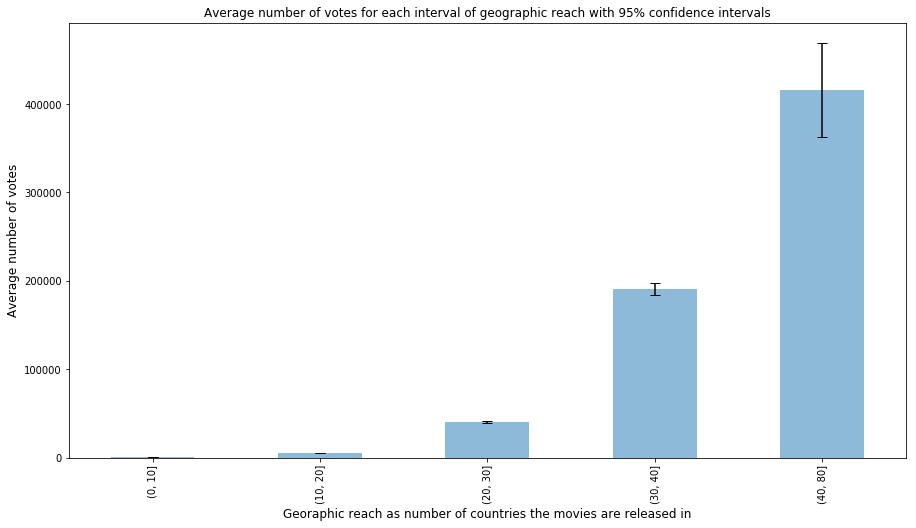

In [274]:
movies_stats_regions_votes = movies_stats_regions['numVotes']
movies_stats_regions_votes['errlo']  = movies_stats_regions_votes['nanmean'] - \
                                 movies_stats_regions_votes['95% CI mean'].apply(lambda x: x[0])

movies_stats_regions_votes['errhi']  = movies_stats_regions_votes['95% CI mean'].apply(lambda x: x[1]) -\
                                 movies_stats_regions_votes['nanmean']

movies_stats_regions_votes.plot(kind='bar', y='nanmean', yerr=movies_stats_regions_votes[['errlo','errhi']].T.values, \
                      alpha=0.5, capsize=5, figsize=(15,8), legend=False);

plt.xlabel("Georaphic reach as number of countries the movies are released in", size='large')
plt.ylabel("Average number of votes", size="large")
plt.title("Average number of votes for each interval of geographic reach with 95% confidence" +\
          " intervals" , size="large");

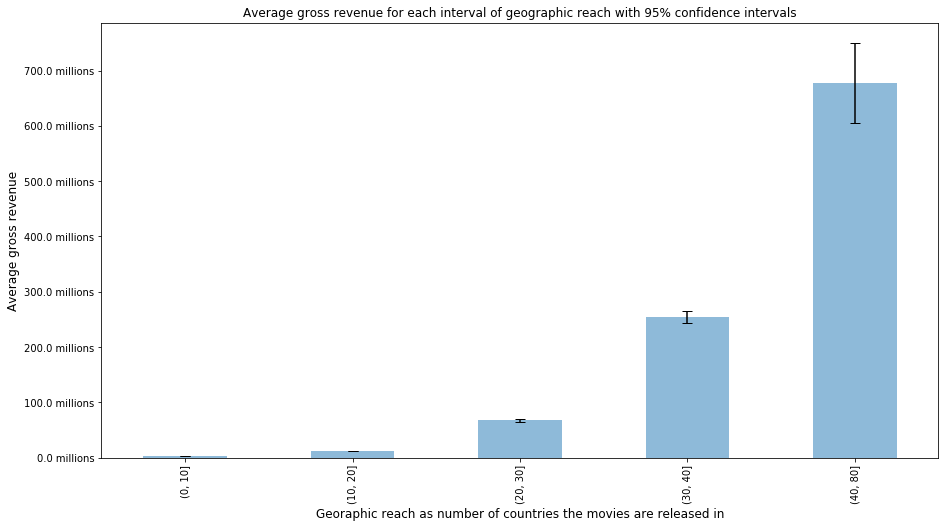

In [204]:
movies_stats_regions_gross = movies_stats_regions['worldwideGross_adjusted']
movies_stats_regions_gross['errlo']  = movies_stats_regions_gross['nanmean'] - \
                                 movies_stats_regions_gross['95% CI mean'].apply(lambda x: x[0])

movies_stats_regions_gross['errhi']  = movies_stats_regions_gross['95% CI mean'].apply(lambda x: x[1]) -\
                                 movies_stats_regions_gross['nanmean']

g=movies_stats_regions_gross.plot(kind='bar', y='nanmean', yerr=movies_stats_regions_gross[['errlo','errhi']].T.values, \
                      alpha=0.5, capsize=5, figsize=(15,8), legend=False);

plt.xlabel("Georaphic reach as number of countries the movies are released in", size='large')
plt.ylabel("Average gross revenue", size="large")
plt.title("Average gross revenue for each interval of geographic reach with 95% confidence" +\
          " intervals" , size="large");
ylabels = ['{:,.1f}'.format(x) + ' millions' for x in g.get_yticks()/1000000]
g.set_yticklabels(ylabels);

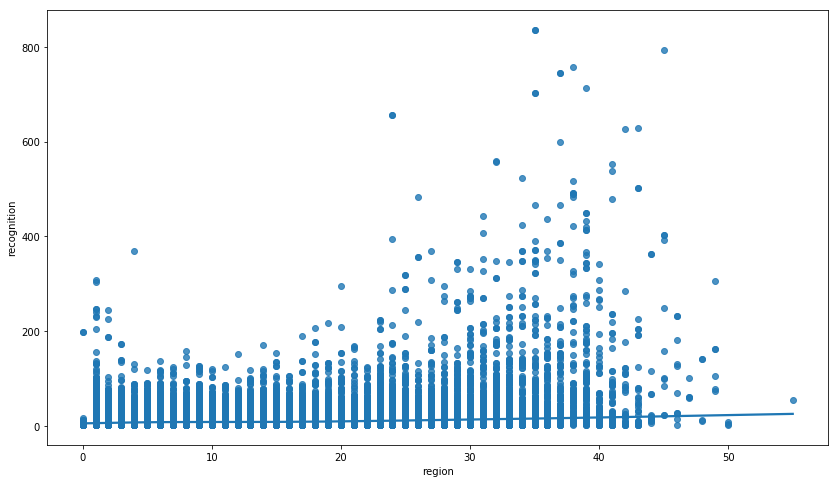

In [162]:
fig = plt.figure(figsize=(14,8))
sns.regplot(recognized_movies[recognized_movies['recognition']>0]['region'], recognized_movies[recognized_movies['recognition']>0]['recognition'], lowess=True)

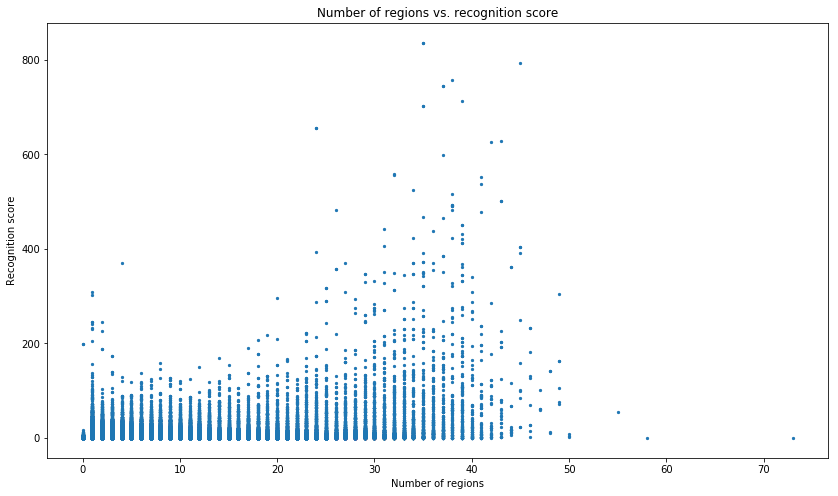

In [82]:
fig = plt.figure(figsize=(14,8))

plt.scatter(recognized_movies['region'],\
            recognized_movies['recognition'], s=5);

plt.title("Number of regions vs. recognition score")
#plt.yscale('symlog')
plt.xlabel('Number of regions')
plt.ylabel('Recognition score');

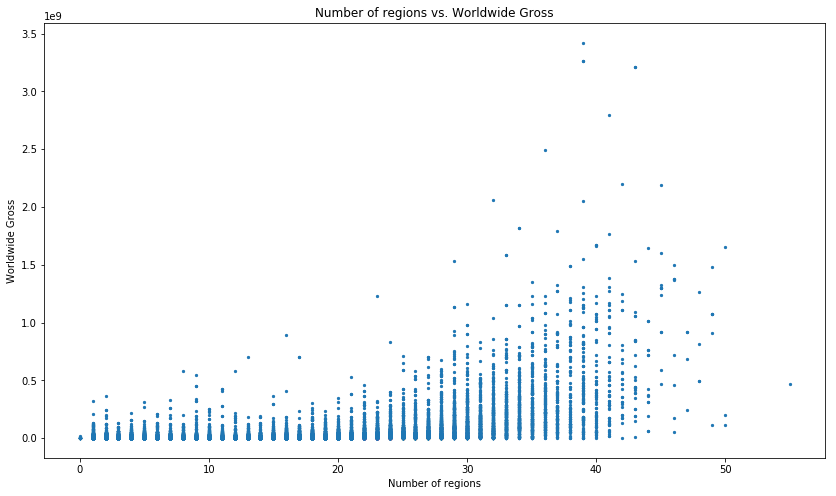

In [83]:
fig = plt.figure(figsize=(14,8))

plt.scatter(recognized_movies['region'],\
            recognized_movies['worldwideGross_adjusted'], s=5);

plt.title("Number of regions vs. Worldwide Gross")
#plt.yscale('symlog')
plt.xlabel('Number of regions')
plt.ylabel('Worldwide Gross');

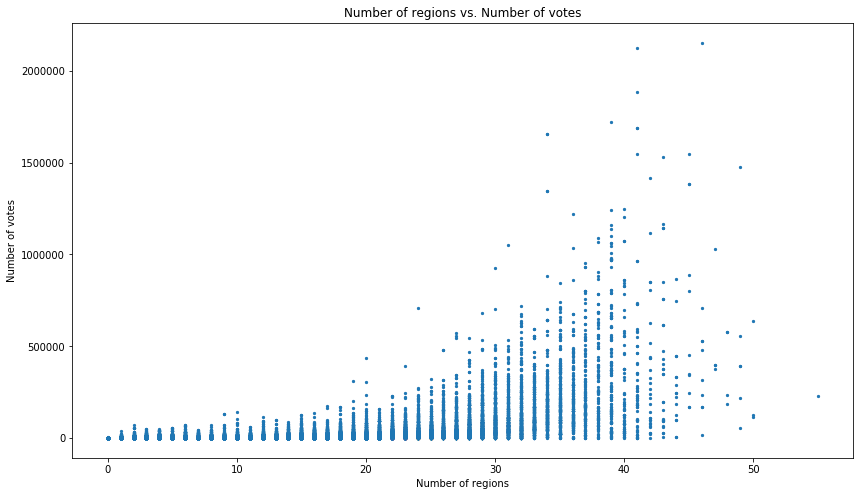

In [84]:
fig = plt.figure(figsize=(14,8))

plt.scatter(recognized_movies['region'],\
            recognized_movies['numVotes'], s=5);

plt.title("Number of regions vs. Number of votes")
#plt.yscale('symlog')
plt.xlabel('Number of regions')
plt.ylabel('Number of votes');

In [205]:
georeach_recognition=recognized_movies.groupby('region').agg({'recognition': ['median','std']})

Text(0, 0.5, 'Mean recognition score')

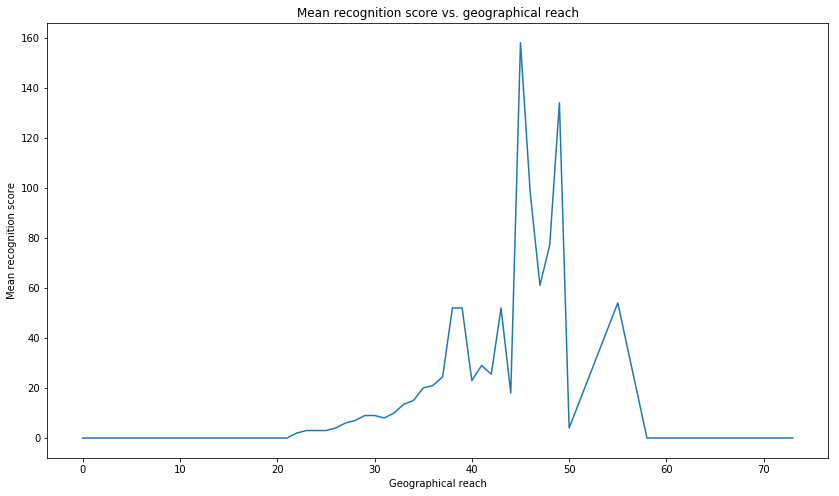

In [206]:
fig = plt.figure(figsize=(14,8))
plt.plot(georeach_recognition.index,georeach_recognition[('recognition','median')])
plt.title('Mean recognition score vs. geographical reach')
plt.xlabel('Geographical reach')
plt.ylabel('Mean recognition score')

In [207]:
georeach_votes=recognized_movies.groupby('region').agg({'numVotes': ['median','std']})

Text(0, 0.5, 'Mean number of votes')

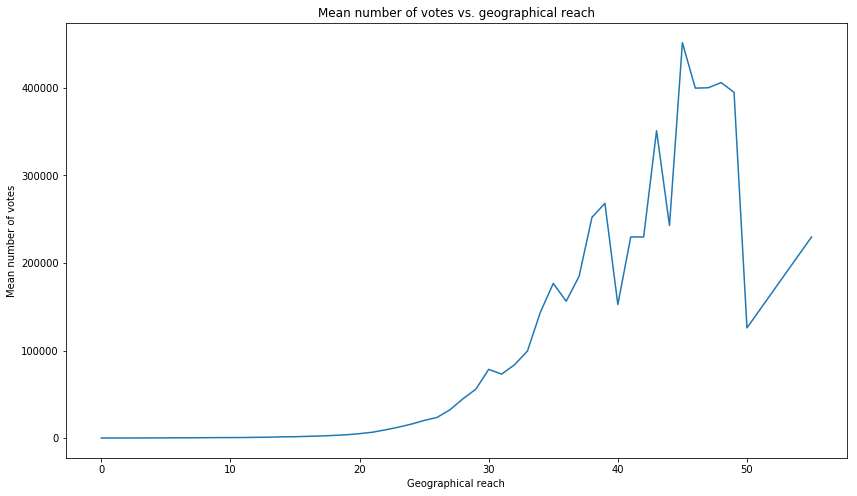

In [209]:
fig = plt.figure(figsize=(14,8))
plt.plot(georeach_votes.index,georeach_votes[('numVotes','median')])
plt.title('Mean number of votes vs. geographical reach')
plt.xlabel('Geographical reach')
plt.ylabel('Mean number of votes')

In [89]:
georeach_gross=recognized_movies.groupby('region').agg({'worldwideGross_adjusted': ['mean','std']})

Text(0, 0.5, 'Mean worldwide gross')

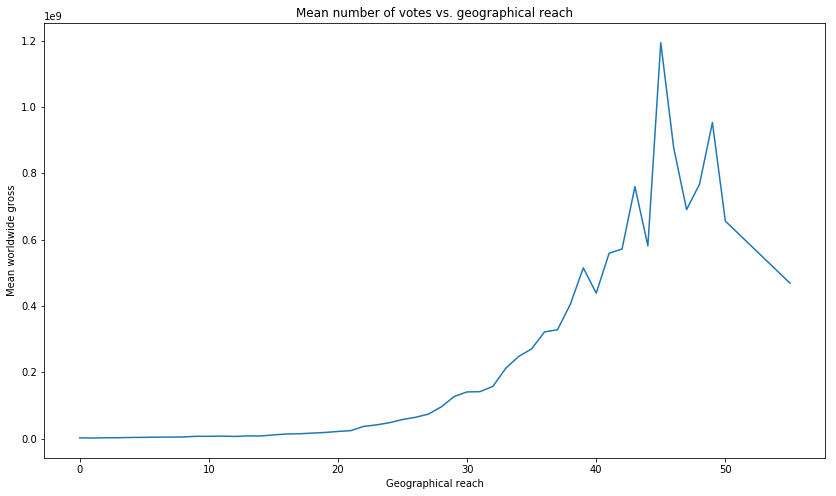

In [90]:
fig = plt.figure(figsize=(14,8))
plt.plot(georeach_gross.index,georeach_gross[('worldwideGross_adjusted','mean')])
plt.title('Mean number of votes vs. geographical reach')
plt.xlabel('Geographical reach')
plt.ylabel('Mean worldwide gross')

In [91]:
movie_akas_recognized=movie_akas.merge(recognized_movies,how='outer', on='tconst')

In [92]:
region_recognition=movie_akas_recognized.groupby('country').agg({'recognition': ['mean','std','nunique']}).reset_index()


In [93]:
top20_region_recognition=region_recognition.sort_values(('recognition','mean'), ascending=False).head(20)

Text(0.5, 1.0, 'Top 20 regions according to mean recognition score')

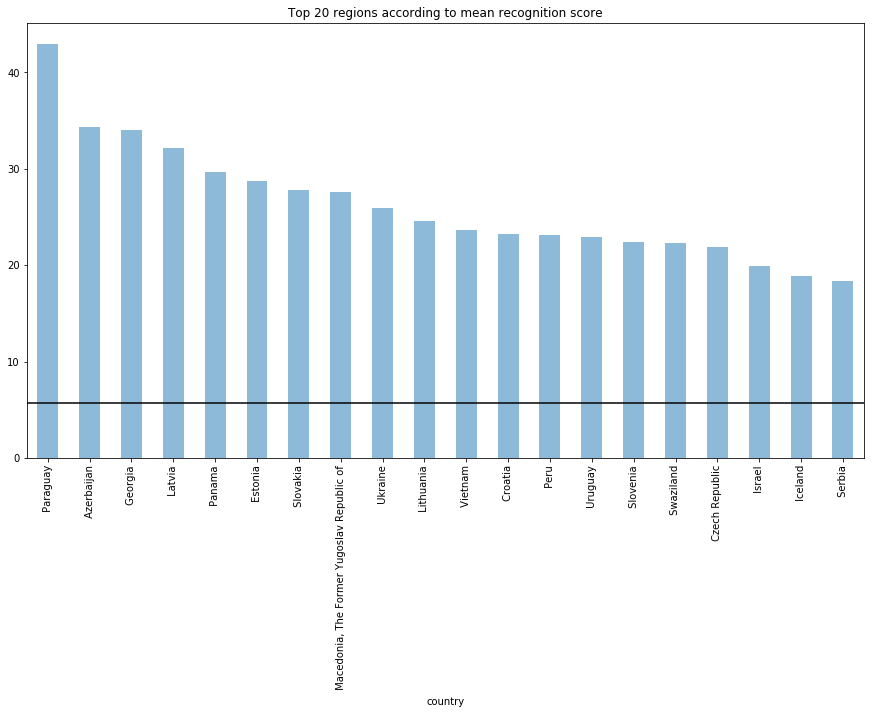

In [94]:
top20_region_recognition.plot(kind='bar',x='country', y=('recognition','mean'), alpha=0.5, capsize=5, figsize=(15,8), legend=False)
plt.hlines(region_recognition[('recognition','mean')].mean(),-1,20)
plt.title('Top 20 regions according to mean recognition score')

Text(0.5, 1.0, 'Top 20 regions according to mean number of votes')

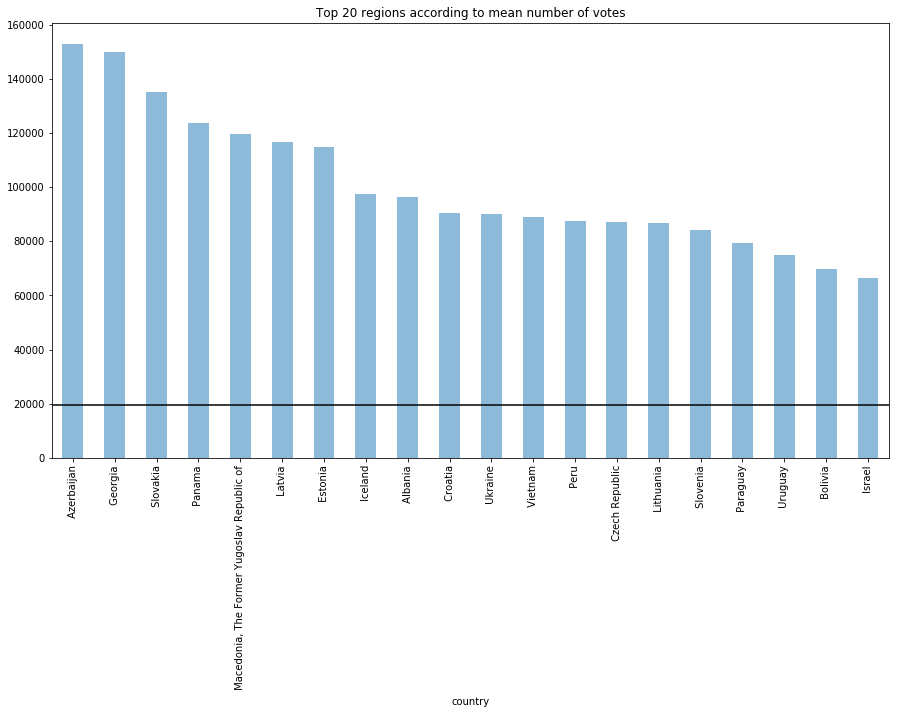

In [95]:
region_votes=movie_akas_recognized.groupby('country').agg({'numVotes': ['mean','std','nunique']}).reset_index()

top20_region_votes=region_votes.sort_values(('numVotes','mean'), ascending=False).head(20)

top20_region_votes.plot(kind='bar',x='country', y=('numVotes','mean'), alpha=0.5, capsize=5, figsize=(15,8), legend=False)
plt.hlines(region_votes[('numVotes','mean')].mean(),-1,20)
plt.title('Top 20 regions according to mean number of votes')

In [163]:
top20_region_votes

country       numVotes  \
                                                           mean   
14                                    Azerbaijan  152893.439364   
79                                       Georgia  149975.605919   
197                                     Slovakia  135241.247462   
169                                       Panama  123727.713528   
129   Macedonia, The Former Yugoslav Republic of  119594.605714   
120                                       Latvia  116780.914367   
67                                       Estonia  114783.333549   
99                                       Iceland   97421.966123   
1                                        Albania   96269.020270   
54                                       Croatia   90468.921775   
228                                      Ukraine   90121.209689   
237                                      Vietnam   88766.663793   
172                                         Peru   87440.542234   
57                                Czech Republic   87267.440333   
126                                    Lithuania   86720.634874   
198                                     Slovenia   84174.851300   
171                                     Paraguay   79298.000000   
233                                      Uruguay   75099.819680   
25                                       Bolivia   69607.272727   
106                                       Israel   66284.044921   

                            
               std nunique  
14   292451.279221     332  
79   284162.660933     418  
197  226101.716379    2120  
169  272936.685463     272  
129  300024.840648     105  
120  200816.153702    1496  
67   192335.525678    3266  
99   255288.688767     459  
1    234863.814919     306  
54   162860.917652    4777  
228  161261.113728    5505  
237  183004.836684    1778  
172  172096.305709    4151  
57   170146.701976    4184  
126  158338.377986    5820  
198  164082.389569    4410  
171  158926.074988      43  
233  163551.921742    4069  
25   151730.485640     116  
106  149920.982010    3330

Text(0.5, 1.0, 'Top 20 regions according to mean gross revenue')

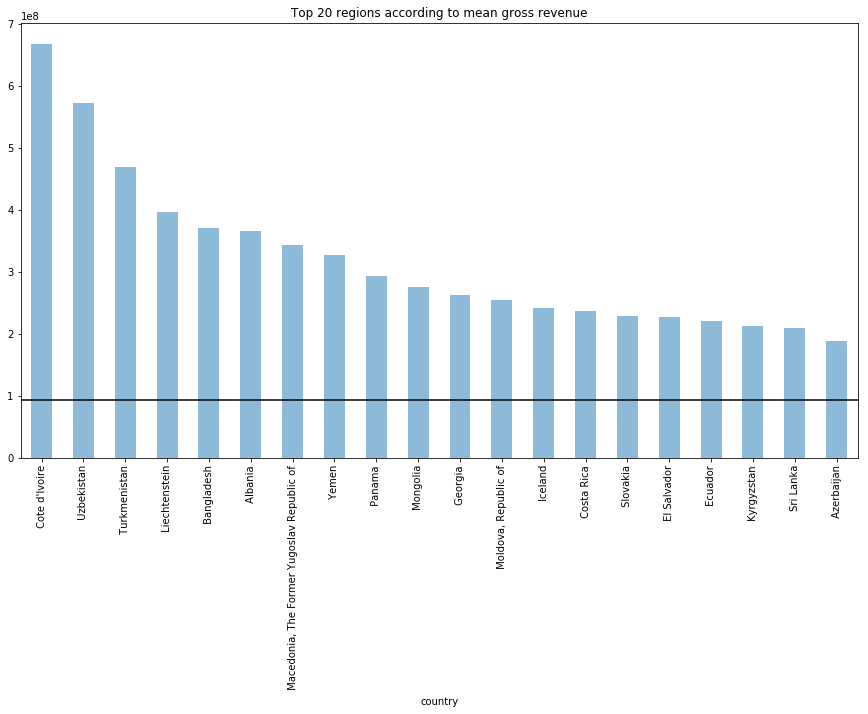

In [96]:
region_gross=movie_akas_recognized.groupby('country').agg({'worldwideGross_adjusted': ['mean','std','nunique']}).reset_index()

top20_region_gross=region_gross.sort_values(('worldwideGross_adjusted','mean'), ascending=False).head(20)

top20_region_gross.plot(kind='bar',x='country', y=('worldwideGross_adjusted','mean'), alpha=0.5, capsize=5, figsize=(15,8), legend=False)
plt.hlines(region_gross[('worldwideGross_adjusted','mean')].mean(),-1,20)
plt.title('Top 20 regions according to mean gross revenue')

In [287]:
countries=movie_akas_recognized.groupby('country')['tconst']\
         .agg({'size': len, 'set': lambda x: set(x)})

In [288]:
countries = countries[countries['size']>10000].reset_index()

In [289]:
countries

,country,set,size
0,Argentina,"{tt0026438, tt0485083, tt0489685, tt0498440, t...",48985
1,Australia,"{tt1059673, tt0549330, tt2559368, tt5859992, t...",63133
2,Austria,"{tt0366687, tt1282460, tt1654007, tt5946838, t...",25826
3,Belgium,"{tt0063034, tt0271394, tt0270755, tt0072392, t...",25460
4,Brazil,"{tt0486474, tt0026438, tt0107979, tt0196902, t...",90258
5,Bulgaria,"{tt0167227, tt4291032, tt0372650, tt0064639, t...",26626
6,Canada,"{tt2798456, tt2642134, tt4228982, tt0107979, t...",108309
7,China,"{tt11177790, tt10833604, tt4793824, tt4244190,...",10676
8,Croatia,"{tt0064639, tt0052861, tt4954522, tt0060278, t...",10709
9,Czech Republic,"{tt3602034, tt2607642, tt0297181, tt1087864, t...",13608


In [238]:
jaccard = df_crossjoin(countries.drop('size'))

In [239]:
jaccard['distance'] = np.vectorize(jaccard_similarity)(jaccard['set_x'], jaccard['set_y'])
jaccard = jaccard.drop(['set_x', 'set_y'], axis=1)

In [240]:
jaccard

,country_x,size_x,country_y,size_y,distance
0,Argentina,48985,Argentina,48985,1.00
1,Argentina,48985,Australia,63133,0.05
2,Argentina,48985,Austria,25826,0.06
3,Argentina,48985,Belgium,25460,0.05
4,Argentina,48985,Brazil,90258,0.16
...,...,...,...,...,...
1439,United States,924338,Sweden,55171,0.03
1440,United States,924338,Turkey,36586,0.02
1441,United States,924338,Ukraine,11891,0.01
1442,United States,924338,United Kingdom (Great Britain),433112,0.03


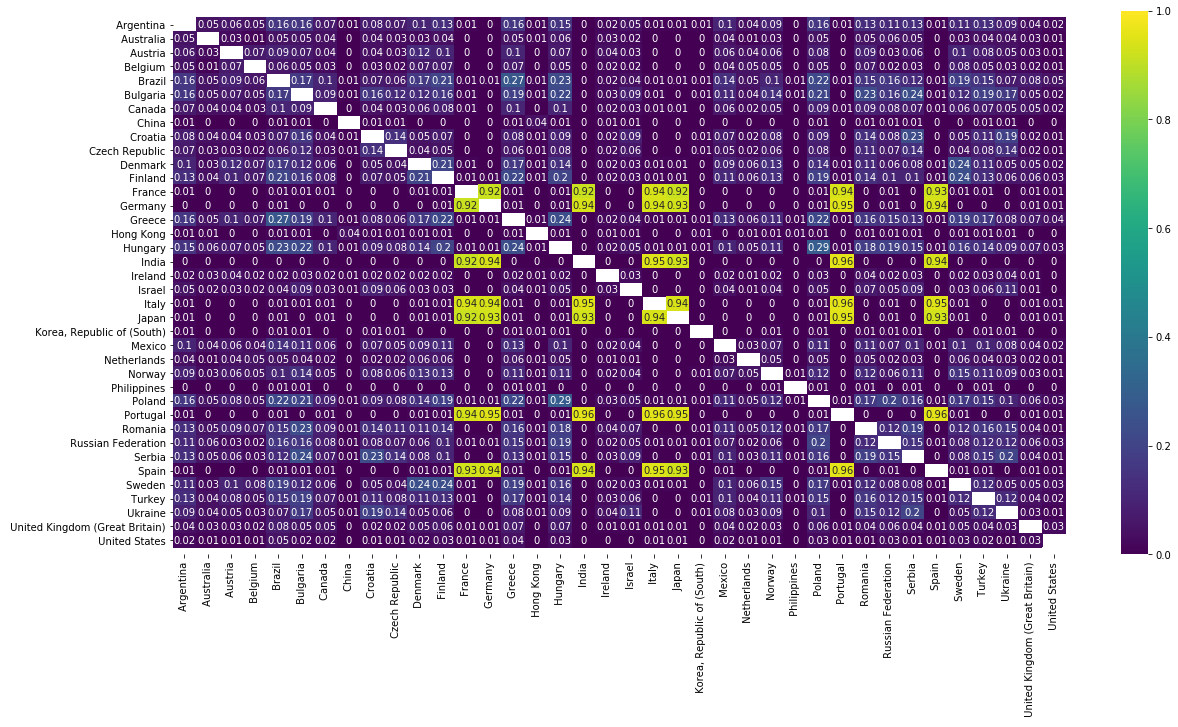

In [247]:

jaccard_pivot = jaccard.pivot(index='country_x', columns='country_y', values='distance')
plt.figure(figsize=(20,10))

mask = np.zeros((len(jaccard_pivot), len(jaccard_pivot)))
mask[np.diag_indices(len(jaccard_pivot))] = True

ax = sns.heatmap(jaccard_pivot, mask=mask, fmt="g", cmap='viridis', vmax = 1, annot=True)
ax.set_ylim(len(jaccard_pivot)+0.5, -0.5);
ax.set_xlabel('');
ax.set_ylabel('');

### Budget

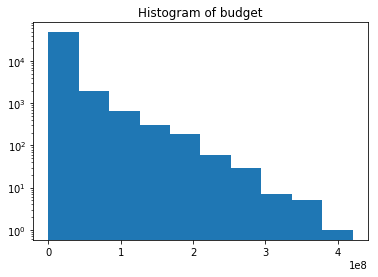

In [250]:
plt.hist(recognized_movies.budget_adjusted, bins=10)
plt.yscale('log')
plt.title('Histogram of budget')
plt.show()

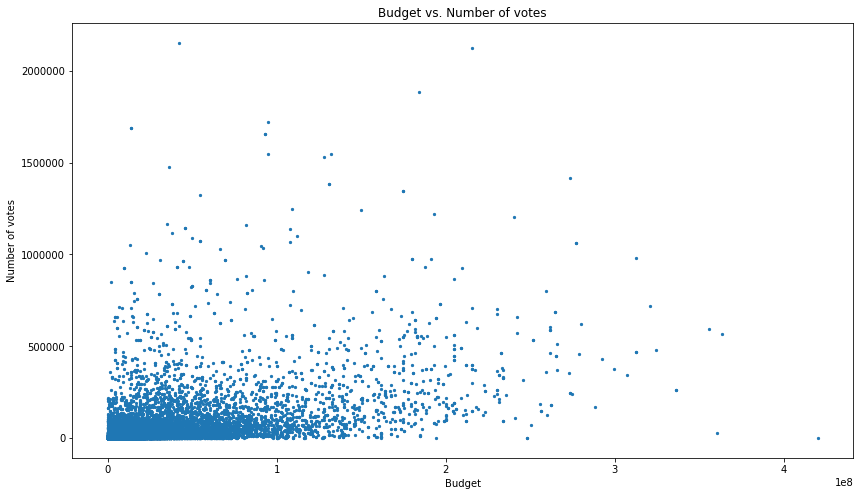

In [167]:
fig = plt.figure(figsize=(14,8))

plt.scatter(recognized_movies['budget_adjusted'],\
            recognized_movies['numVotes'], s=5);

plt.title("Budget vs. Number of votes")
#plt.yscale('symlog')
plt.xlabel('Budget')
plt.ylabel('Number of votes');

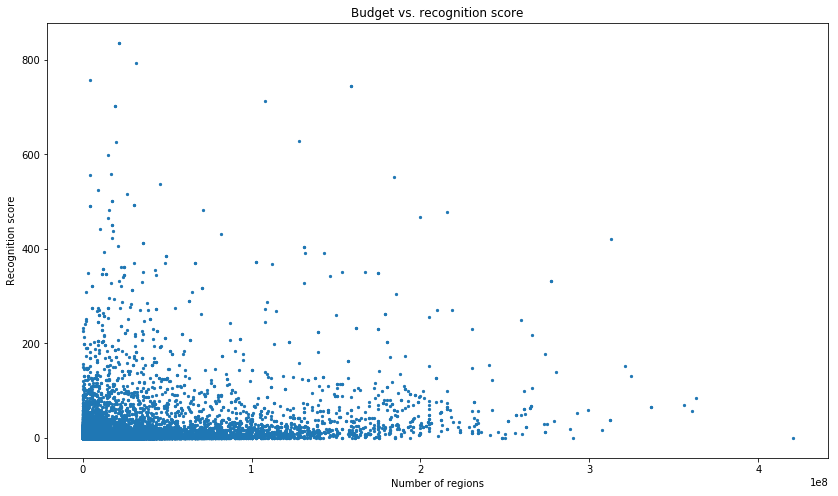

In [166]:
fig = plt.figure(figsize=(14,8))

plt.scatter(recognized_movies['budget_adjusted'],\
            recognized_movies['recognition'], s=5);

plt.title("Budget vs. recognition score")
#plt.yscale('symlog')
plt.xlabel('Number of regions')
plt.ylabel('Recognition score');

In [269]:
intervals=[i*10**8 for i in [0,0.25,0.5,0.75,1,1.5,2,5]]
movies_stats_budget = recognized_movies.groupby(pd.cut(recognized_movies['budget_adjusted'], intervals))\
               ['recognition', 'numVotes', 'worldwideGross_adjusted']\
                 .agg([cast_count, np.nanmean, np.nanstd, np.nanmin, np.nanmax, np.nanmedian, \
                       lambda x: bootstrap_mean_ci(x, 5, 1000), lambda x: bootstrap_median_ci(x, 5, 1000),\
                       lambda x: np.nanpercentile(x, q = 75), lambda x: np.nanpercentile(x, q = 90),\
                       lambda x: np.nanpercentile(x, q = 95), lambda x: np.nanpercentile(x, q = 99)])

movies_stats_budget = movies_stats_budget.rename(columns={'<lambda_0>': '95% CI mean', '<lambda_1>': '95% CI median',\
                                '<lambda_2>': '75%','<lambda_3>': '90%', '<lambda_4>': '95%','<lambda_5>': '99%'})

In [2]:
movies_stats_budget#.reindex(new_indices)

NameError: name 'movies_stats_budget' is not defined

In [ ]:
new_indices = ["(0, 25]", "(25, 50]", "(50, 75]", "(75, 100]", "(100, 150]", "(150, 200]", "(200, 500]"]

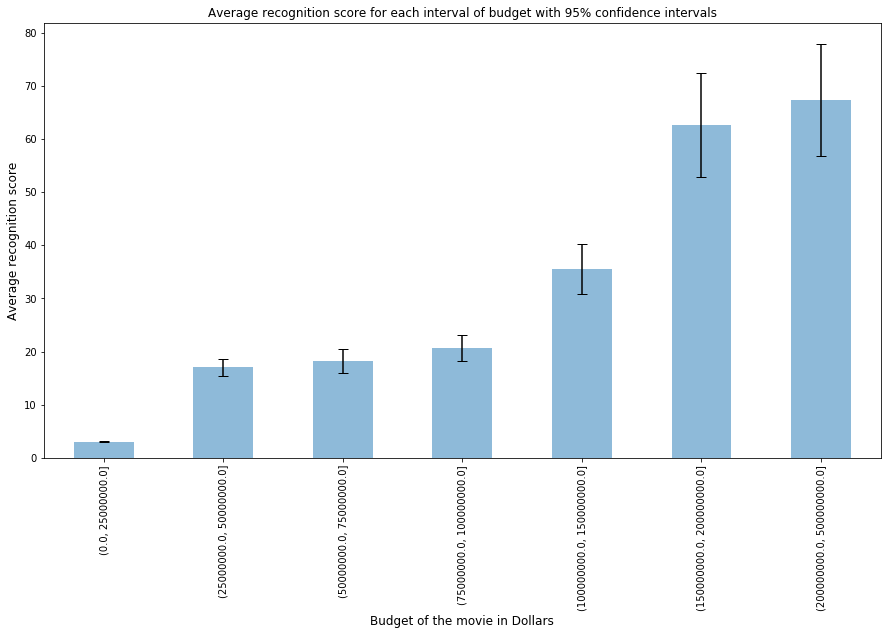

In [271]:
movies_stats_budget_rec = movies_stats_budget['recognition']
movies_stats_budget_rec['errlo']  = movies_stats_budget_rec['nanmean'] - \
                                 movies_stats_budget_rec['95% CI mean'].apply(lambda x: x[0])

movies_stats_budget_rec['errhi']  = movies_stats_budget_rec['95% CI mean'].apply(lambda x: x[1]) -\
                                 movies_stats_budget_rec['nanmean']

movies_stats_budget_rec.plot(kind='bar', y='nanmean', yerr=movies_stats_budget_rec[['errlo','errhi']].T.values, \
                      alpha=0.5, capsize=5, figsize=(15,8), legend=False);

plt.xlabel("Budget of the movie in millions of  2019 USdollars", size='large')
plt.ylabel("Average recognition score", size="large")
plt.title("Average recognition score for each interval of budget with 95% confidence" +\
          " intervals" , size="large");

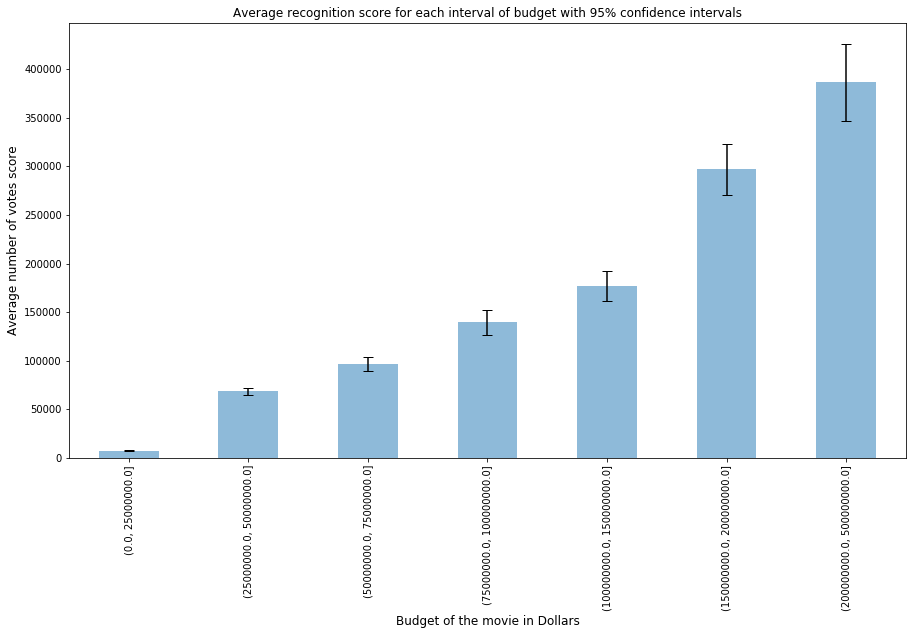

In [272]:
movies_stats_budget_votes = movies_stats_budget['numVotes']
movies_stats_budget_votes['errlo']  = movies_stats_budget_votes['nanmean'] - \
                                 movies_stats_budget_votes['95% CI mean'].apply(lambda x: x[0])

movies_stats_budget_votes['errhi']  = movies_stats_budget_votes['95% CI mean'].apply(lambda x: x[1]) -\
                                 movies_stats_budget_votes['nanmean']

movies_stats_budget_votes.plot(kind='bar', y='nanmean', yerr=movies_stats_budget_votes[['errlo','errhi']].T.values, \
                      alpha=0.5, capsize=5, figsize=(15,8), legend=False);

plt.xlabel("Budget of the movie in Dollars", size='large')
plt.ylabel("Average number of votes score", size="large")
plt.title("Average recognition score for each interval of budget with 95% confidence" +\
          " intervals" , size="large");

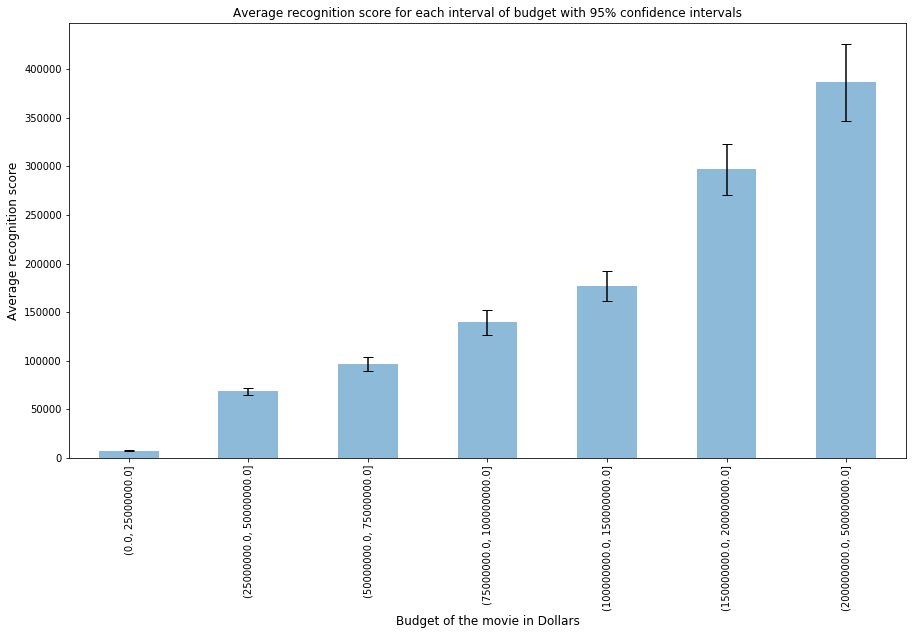

In [273]:
movies_stats_budget_ = movies_stats_budget['worldwideGross_adjusted']
movies_stats_budget_votes['errlo']  = movies_stats_budget_votes['nanmean'] - \
                                 movies_stats_budget_votes['95% CI mean'].apply(lambda x: x[0])

movies_stats_budget_votes['errhi']  = movies_stats_budget_votes['95% CI mean'].apply(lambda x: x[1]) -\
                                 movies_stats_budget_votes['nanmean']

movies_stats_budget_votes.plot(kind='bar', y='nanmean', yerr=movies_stats_budget_votes[['errlo','errhi']].T.values, \
                      alpha=0.5, capsize=5, figsize=(15,8), legend=False);

plt.xlabel("Budget of the movie in Dollars", size='large')
plt.ylabel("Average recognition score", size="large")
plt.title("Average recognition score for each interval of budget with 95% confidence" +\
          " intervals" , size="large");